https://www.kaggle.com/code/kidoen/eda-plotly-kmeans-dbscan-silhouetteanalysis#DBSCAN-CLUSTERING
https://www.ims.uni-stuttgart.de/documents/team/schulte/theses/phd/algorithm.pdf

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from sklearn.cluster import DBSCAN
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

In [3]:
def result(actual, predicted):
    """
    This function will find generate the confusion matrix and compute the required metrics

    Args:
      actual : Actual label or true label
      predicted : Predicted label
    """
    cm = confusion_matrix(actual,predicted)
    plt.figure().set_figwidth(0.5)
    plt.figure().set_figheight(3)
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['In-Dist','Out-Dist'],
            yticklabels=['In-Dist','Out-Dist'])
    plt.ylabel('Prediction',fontsize=10)
    plt.xlabel('Actual',fontsize=10)
    plt.title('Confusion Matrix',fontsize=15)

    plt.show()

    acc = accuracy_score(actual,predicted)
    precision = precision_score(actual,predicted)
    recall = recall_score(actual,predicted)
    f1 = f1_score(actual,predicted)
    print("Accuracy : ",acc)
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("f1 : ",f1)

In [4]:
def row_counter(dicts):
  """
  This function will count how many rows of data it is having and print the result

  Args:
    dict : takes a dictionary as input
  """
  single_count = 0
  double_count = 0
  for k, v in dicts.items():
    if len(v)>1:
      double_count = double_count + 1
    else:
      single_count = single_count + 1
  print("Number of single rows: ",single_count)
  print("Number of more than 1 row: ",double_count)

In [5]:
def list_dictator(df_name, key, value):
  """
  This function returns a dictionary which has a list of values

  Args:
    df_name : is the name of the dataframe
    key : column name of the dataframe which acts as the key of the dictionary
    value : column name of the dataframe which acts as the value of the dictionary
  """
  new_dict = dict()
  for i in df_name.index:
    k = df_name[key][i]
    v = df_name[value][i]
    if k not in new_dict:
      new_dict[k] = [v]
    else:
      new_dict[k].append(v)
  return new_dict

# Test Data

In [6]:
file_path = "/content/drive/My Drive/OOD/preprocessed_wdcproductsmulti80cc20rnd050un_gs.pkl.gz"
test_df = pd.read_pickle(file_path)

# 80 corner cases 20 random 50 unseen test data
# test_df = pd.read_pickle('../data/Test Data/preprocessed_wdcproductsmulti80cc20rnd050un_gs.pkl.gz')

In [7]:
test_df.shape

(1000, 10)

In [8]:
test_df[test_df["brand"]=="Shinamo"]

,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen


In [9]:
test_df.head(5)

,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen
0,84745207,Oki,OKI C831/841 Cyan Toner 10K,NaN,219.74,GBP,NaN,796023,796023,False
1,39759360,NaN,"Garmin Forerunner 735XT - Replacement Band, Ye...",Stay stylish and sport-ready by swapping out y...,39.93,AUD,NaN,1382074,1382074,True
2,14159368,NaN,Original Epson T8651 Black Ink Cartridge (C13T...,Buy Epson T8651 original high capacity black i...,NaN,NaN,NaN,193507,193507,False
3,96150856,SEIKO WATCH,seiko solar gents alarm chronograph watch,SEIKO SOLAR GENTS ALARM CHRONOGRAPH WATCHMOVEM...,369.0,EUR,NaN,174229,174229,True
4,35724064,NaN,Ubiquiti UVC-G3-FLEX UniFI IP Dome Camera,NaN,$‎147.95,USD,NaN,192122,192122,False


In [10]:
test_df["cluster_id"].nunique()

500

In [11]:
test_df["unseen"].nunique()

2

In [12]:
print("Number of cluster with unseen == True",test_df[test_df["unseen"]==True]["cluster_id"].nunique())
print("Number of cluster with unseen == False",test_df[test_df["unseen"]==False]["cluster_id"].nunique())

Number of cluster with unseen == True 250
Number of cluster with unseen == False 250


In [13]:
test_df.groupby(["cluster_id"]).count()

,id,brand,title,description,price,priceCurrency,specTableContent,label,unseen
cluster_id,,,,,,,,,
4559,2,0,2,2,2,2,0,2,2
9046,2,1,2,2,2,2,0,2,2
21809,2,0,2,2,2,2,0,2,2
26514,2,0,2,1,2,1,0,2,2
27477,2,1,2,0,2,2,0,2,2
...,...,...,...,...,...,...,...,...,...
65412764,2,0,2,2,2,2,0,2,2
68024517,2,1,2,2,2,2,0,2,2
72054429,2,0,2,2,2,2,0,2,2


In [14]:
test_df[test_df["cluster_id"]==977750]

,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen
6,4338951,NaN,Manfrotto MK290LTA3 Video Tripod with Fluid Head,"For vlogging, travel and other mobile video pu...",279.95,AUD,NaN,977750,977750,True
463,20281251,NaN,290 LIGHT ALU BEFREE LIVE FLUID VIDEO HE,Manfrotto 290 light aluminium tripod with befr...,4.190002E2,NZD,NaN,977750,977750,True


In [15]:
test_df = test_df.fillna('')
# Below line will create a new column where it gives a 1 when unseen=True and vice versa
test_df['unseen_int'] = test_df['unseen'].astype(int)

# Finding similarity

## Cosine Similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfidfvectorizer = TfidfVectorizer(stop_words = "english", analyzer = "word")

In [ ]:
tfidf = tfidfvectorizer.fit_transform(test_df["title"])

In [ ]:
tfidf.shape

(1000, 2426)

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix based on the tfidf_matrix
content_correlation = linear_kernel(tfidf, tfidf)

In [ ]:
print("content_correlation.shape: ",(content_correlation.shape))

content_correlation.shape:  (1000, 1000)


In [ ]:
non_zero_count = np.count_nonzero(content_correlation)

# Print the result
print("Number of non-zero values:", non_zero_count)

Number of non-zero values: 58288


In [ ]:
cosine_sim = list(content_correlation[0])

In [ ]:
# sorted_list_with_indices = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)

# # Get the top 5 values with their indices
# top_5_values_with_indices = sorted_list_with_indices[:5]

# # Print the top 5 values with their indices
# for index, value in top_5_values_with_indices:
#     print(f"Index: {index}, Value: {value}")
#     print("unseen: ",test_df.iloc[index]["unseen"])
#     print(test_df.iloc[index]["cluster_id"]," ",test_df.iloc[index]["title"])
#     print("-------------------------------------")

Below cell will create a dictionary which has the key as rows and values as tuple like :(index, similarity_value, unseen, cluster_id)

In [ ]:
sim_dict = dict()
for row in test_df.index:
  cosine_sim = list(content_correlation[row])
  sorted_list_with_indices = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)
  top_5_values_with_indices = sorted_list_with_indices[:5]
  info_list = []
  for index, value in sorted_list_with_indices:
      info_list.append((index, round(value,4), test_df.iloc[index]["unseen"], test_df.iloc[index]["cluster_id"]))
  sim_dict[row] = info_list

In [ ]:
sim_dict[15]

Computing the similarity score between the in-dist and out-dist

1.   During max value calculation: if the row we are checking is unseen=False then we take the 2nd max similar value with unseen=False and the 1st max similar with unseen=True. If the row we are checking is unseen=True then we take the 2nd max similar value with unseen=True and the 1st max similar with unseen=False
2.   During min value calculation: if the row we are checking is unseen=False or unseen=True, we take the 1st non zero min similar


In [ ]:
sim_list = []
count = 0
for row in sim_dict.keys():
  # print("row: ",row)
  min_true = 0
  min_false = 0
  max_true = 0
  max_false = 0
  avg_true = 0
  avg_false = 0
  # Computing the max similar values
  max_true_values = [(t[1], t[3]) for t in sim_dict[row] if t[2]]
  max_false_values = [(t[1], t[3]) for t in sim_dict[row] if not t[2]]

  if test_df.iloc[row]["unseen_int"]:
    # Find the 2nd largest value and cluster_id (when True)
    max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1] if len(max_true_values) >= 2 else None
    sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1:6]
    sum_true = sum(item[0] for item in sum_true_list)
    avg_true = round(sum_true/5,3)

    # Find the 1nd largest value (when False)
    max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[0] if len(max_false_values) >= 2 else None
    sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[:5]
    sum_false = sum(item[0] for item in sum_false_list)
    avg_false = round(sum_false/5,3)
  else:
    # Find the largest value and cluster_id (when True)
    max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[0] if len(max_true_values) >= 2 else None
    sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[:5]
    sum_true = sum(item[0] for item in sum_true_list)
    avg_true = round(sum_true/5,3)

    # Find the 2nd largest value (when False)
    max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1] if len(max_false_values) >= 2 else None
    sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1:6]
    sum_false = sum(item[0] for item in sum_false_list)
    avg_false = round(sum_false/5,3)

  # Computing the min similar values
  min_true_values = [(t[1], t[3]) for t in sim_dict[row] if t[2] and t[1] !=0 ]
  min_false_values = [(t[1], t[3]) for t in sim_dict[row] if not t[2] and t[1] !=0]

  min_true = sorted(min_true_values, key=lambda x: x[0])[0] if len(min_true_values) >= 2 else (0,"")

  min_false = sorted(min_false_values, key=lambda x: x[0])[0] if len(min_false_values) >= 2 else (0,"")

  sim_list.append({"Max_Sim Out-Dist":max_true[0], "Max_Sim Out-Dist ID":max_true[1],
                   "Max_Sim In-Dist":max_false[0], "Max_Sim In-Dist ID":max_false[1],
                   "Min_Sim Out-Dist":min_true[0], "Min_Sim Out-Dist ID":min_true[1],
                   "Min_Sim In-Dist":min_false[0], "Min_Sim In-Dist ID":min_false[1],
                  "Avg Sim Out-Dist":avg_true, "Avg Sim In-Dist ":avg_false})


  # print("Max similar Value and Cluster ID (when True):", max_true)
  # print("Max similar Value and Cluster_ID (when False):", max_false)
  # print("Min similar Value and Cluster ID (when True):", min_true)
  # print("Min similar Value and Cluster_ID (when False):", min_false)
  # print("Avg similarity (when True):", avg_true)
  # print("Avg similarity (when False):", avg_false)
  # sim_list.append({"Max_Sim True":max_true[0], "Max_Sim True ID":max_true[1],
  #                  "Max_Sim False":max_false[0], "Max_Sim False ID":max_false[1],
  #                  "Min_Sim True":min_true[0], "Min_Sim True ID":min_true[1],
  #                  "Min_Sim False":min_false[0], "Min_Sim False ID":min_false[1],
  #                 "Avg Sim True":avg_true, "Avg Sim False":avg_false})



Dataframe with a empty column means value is not present. For instance for row 0 in 80cc20rnd050un the min false value is 0 because the False is starting with the minimum simialrity of 0

In [ ]:
sim_list[15]

{'Max_Sim Out-Dist': 0.7427,
 'Max_Sim Out-Dist ID': 6128077,
 'Max_Sim In-Dist': 0.0,
 'Max_Sim In-Dist ID': 796023,
 'Min_Sim Out-Dist': 0.1453,
 'Min_Sim Out-Dist ID': 1550079,
 'Min_Sim In-Dist': 0,
 'Min_Sim In-Dist ID': '',
 'Avg Sim Out-Dist': 0.33,
 'Avg Sim False': 0.0}

In [ ]:
dtypes = {'Max_Sim True': float, 'Max_Sim True ID': int,
 'Max_Sim False': float,
 'Max_Sim False ID': int,
 'Min_Sim True': float,
 'Min_Sim True ID': int,
 'Min_Sim False': float,
 'Min_Sim False ID': int,
 'Avg Sim True': float,
 'Avg Sim False': float}


In [ ]:
cosine_df = pd.DataFrame(sim_list)
cosine_df["unseen_int"] = test_df["unseen_int"]
cosine_df.head(5)

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim False,unseen_int
0,0.2747,2377509,0.8745,796023,0.0769,3197204,0.0823,1913870,0.174,0.377,0
1,0.6157,1326265,0.1705,103881,0.0315,68024517,0.0191,1473407,0.511,0.153,1
2,0.3356,412661,0.4172,833964,0.0312,1001541,0.0189,1473407,0.246,0.311,0
3,0.5602,174229,0.2616,4560747,0.0513,888406,0.0599,616115,0.294,0.213,1
4,0.1344,847853,0.7245,266703,0.0651,6710706,0.0693,1069672,0.111,0.588,0


In [ ]:
cosine_df

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim False,unseen_int
0,0.2747,2377509,0.8745,796023,0.0769,3197204,0.0823,1913870,0.174,0.377,0
1,0.6157,1326265,0.1705,103881,0.0315,68024517,0.0191,1473407,0.511,0.153,1
2,0.3356,412661,0.4172,833964,0.0312,1001541,0.0189,1473407,0.246,0.311,0
3,0.5602,174229,0.2616,4560747,0.0513,888406,0.0599,616115,0.294,0.213,1
4,0.1344,847853,0.7245,266703,0.0651,6710706,0.0693,1069672,0.111,0.588,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.3987,1550079,0.0000,796023,0.1353,57414773,0.0000,,0.301,0.000,1
996,0.1470,444165,0.7036,686177,0.0634,4104329,0.0382,1497038,0.123,0.435,0
997,0.6581,3805342,0.1692,1167881,0.0361,2095501,0.0227,616115,0.550,0.097,1
998,0.6292,2043487,0.2265,1037461,0.0650,5779737,0.0641,964764,0.450,0.177,1


In [ ]:
cosine_df[cosine_df["unseen_int"]==1].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim False,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.591608,8.226854e+06,0.199736,2.399507e+06,0.066518,0.046910,0.402242,0.146246,1.0
std,0.176353,1.672670e+07,0.143345,7.261283e+06,0.037981,0.028614,0.157727,0.101465,0.0
min,0.128000,2.651400e+04,0.000000,4.559000e+03,0.018600,0.000000,0.108000,0.000000,1.0
25%,0.454475,8.909672e+05,0.118200,4.726480e+05,0.041900,0.028350,0.279000,0.091750,1.0
50%,0.602000,2.067159e+06,0.159850,9.738410e+05,0.056550,0.046600,0.384000,0.120000,1.0
75%,0.719125,4.374213e+06,0.240725,1.914383e+06,0.077800,0.063225,0.513000,0.182750,1.0
max,0.952500,7.575800e+07,0.875800,5.235830e+07,0.313300,0.201900,0.833000,0.573000,1.0


In [ ]:
cosine_df[cosine_df["unseen_int"]==0].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim False,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.220368,6.803803e+06,0.608569,1.753069e+06,0.054008,0.054300,0.156464,0.422556,0.0
std,0.137194,1.556794e+07,0.181627,4.953957e+06,0.027716,0.038345,0.094103,0.140135,0.0
min,0.000000,2.989700e+04,0.091100,4.559000e+03,0.000000,0.009200,0.000000,0.068000,0.0
25%,0.132675,5.782882e+05,0.485500,3.506210e+05,0.037400,0.033575,0.103000,0.311000,0.0
50%,0.182400,1.721480e+06,0.618150,8.405635e+05,0.051000,0.046450,0.134000,0.431500,0.0
75%,0.278325,3.250894e+06,0.736175,1.915191e+06,0.068600,0.063800,0.188000,0.526250,0.0
max,0.875800,7.368242e+07,1.000000,5.714720e+07,0.236100,0.332100,0.684000,0.767000,0.0


In [ ]:
cosine_df.head(3)

,Max_Sim True,Max_Sim True ID,Max_Sim False,Max_Sim False ID,Min_Sim True,Min_Sim True ID,Min_Sim False,Min_Sim False ID,Avg Sim True,Avg Sim False,unseen_int,title,cluster_id
0,0.2747,2377509,0.8745,796023,0.0769,3197204,0.0823,1913870,0.174,0.377,0,OKI C831/841 Cyan Toner 10K,796023
1,0.6157,1326265,0.1705,103881,0.0315,68024517,0.0191,1473407,0.511,0.153,1,"Garmin Forerunner 735XT - Replacement Band, Ye...",1382074
2,0.3356,412661,0.4172,833964,0.0312,1001541,0.0189,1473407,0.246,0.311,0,Original Epson T8651 Black Ink Cartridge (C13T...,193507


In [ ]:
false_corner_case = 0
true_corner_case = 0
count = 0
for row in cosine_df.index:
  if cosine_df.iloc[row]["unseen_int"] == 0:
    if cosine_df.iloc[row]["cluster_id"] != cosine_df.iloc[row]["Max_Sim False ID"]:
      false_corner_case = false_corner_case + 1
  else:
    if cosine_df.iloc[row]["cluster_id"] != cosine_df.iloc[row]["Max_Sim True ID"]:
      true_corner_case = true_corner_case + 1
  # if count ==3:
  #   break
print("false_corner_case: ",false_corner_case)
print("true_corner_case: ",true_corner_case)

false_corner_case:  224
true_corner_case:  261


## Word Co-Occurrence

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
test_df.head(3)

,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int
0,84745207,Oki,OKI C831/841 Cyan Toner 10K,,219.74,GBP,,796023,796023,False,0
1,39759360,,"Garmin Forerunner 735XT - Replacement Band, Ye...",Stay stylish and sport-ready by swapping out y...,39.93,AUD,,1382074,1382074,True,1
2,14159368,,Original Epson T8651 Black Ink Cartridge (C13T...,Buy Epson T8651 original high capacity black i...,,,,193507,193507,False,0


In [ ]:
# Define a function for text preprocessing
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [ ]:
word_co_occ = test_df.copy()

In [ ]:
word_co_occ['processed_title'] = word_co_occ['title'].apply(preprocess_text)

In [ ]:
word_co_occ.head(3)

,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int,processed_title
0,84745207,Oki,OKI C831/841 Cyan Toner 10K,,219.74,GBP,,796023,796023,False,0,oki c831/841 cyan toner 10k
1,39759360,,"Garmin Forerunner 735XT - Replacement Band, Ye...",Stay stylish and sport-ready by swapping out y...,39.93,AUD,,1382074,1382074,True,1,"garmin forerunner 735xt - replacement band , y..."
2,14159368,,Original Epson T8651 Black Ink Cartridge (C13T...,Buy Epson T8651 original high capacity black i...,,,,193507,193507,False,0,original epson t8651 black ink cartridge ( c13...


In [ ]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(word_co_occ['processed_title'])

In [ ]:
similarity_matrix = cosine_similarity(dtm, dtm)

In [ ]:
print("Number of non-zero values:", np.count_nonzero(similarity_matrix))
print("Shape of similarity matrix: ",similarity_matrix.shape)

Number of non-zero values: 58484
Shape of similarity matrix:  (1000, 1000)


In [ ]:
word_co_occ_sim_dict = dict()
for row in test_df.index:
  word_co_occ_cosine_sim = list(similarity_matrix[row])
  sorted_list_with_indices = sorted(enumerate(word_co_occ_cosine_sim), key=lambda x: x[1], reverse=True)
  info_list = []
  for index, value in sorted_list_with_indices:
      info_list.append((index, round(value,4), test_df.iloc[index]["unseen"], test_df.iloc[index]["cluster_id"]))
  word_co_occ_sim_dict[row] = info_list

In [ ]:
word_co_occ_sim_dict[0][:5]

[(0, 1.0, False, 796023),
 (249, 0.9129, False, 796023),
 (765, 0.3651, False, 118390),
 (916, 0.3651, False, 140469),
 (986, 0.3333, False, 140469)]

In [ ]:
word_co_occ_sim_list = []
for row in word_co_occ_sim_dict.keys():
  # print("row: ",row)
  min_true = 0
  min_false = 0
  max_true = 0
  max_false = 0
  avg_true = 0
  avg_false = 0
  # Computing the max similar values
  max_true_values = [(t[1], t[3]) for t in word_co_occ_sim_dict[row] if t[2]]
  max_false_values = [(t[1], t[3]) for t in word_co_occ_sim_dict[row] if not t[2]]

  if test_df.iloc[row]["unseen_int"]:
    # Find the 2nd largest value and cluster_id (when True)
    max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1] if len(max_true_values) >= 2 else None
    sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1:6]
    sum_true = sum(item[0] for item in sum_true_list)
    avg_true = round(sum_true/5,3)

    # Find the 1nd largest value (when False)
    max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[0] if len(max_false_values) >= 2 else None
    sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[:5]
    sum_false = sum(item[0] for item in sum_false_list)
    avg_false = round(sum_false/5,3)
  else:
    # Find the largest value and cluster_id (when True)
    max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[0] if len(max_true_values) >= 2 else None
    sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[:5]
    sum_true = sum(item[0] for item in sum_true_list)
    avg_true = round(sum_true/5,3)

    # Find the 2nd largest value (when False)
    max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1] if len(max_false_values) >= 2 else None
    sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1:6]
    sum_false = sum(item[0] for item in sum_false_list)
    avg_false = round(sum_false/5,3)

  # Computing the min similar values
  min_true_values = [(t[1], t[3]) for t in word_co_occ_sim_dict[row] if t[2] and t[1] !=0 ]
  min_false_values = [(t[1], t[3]) for t in word_co_occ_sim_dict[row] if not t[2] and t[1] !=0]

  min_true = sorted(min_true_values, key=lambda x: x[0])[0] if len(min_true_values) >= 2 else (0,"")

  min_false = sorted(min_false_values, key=lambda x: x[0])[0] if len(min_false_values) >= 2 else (0,"")


  # print("Max similar Value and Cluster ID (when True):", max_true)
  # print("Max similar Value and Cluster_ID (when False):", max_false)
  # print("Min similar Value and Cluster ID (when True):", min_true)
  # print("Min similar Value and Cluster_ID (when False):", min_false)
  # print("Avg similarity (when True):", avg_true)
  # print("Avg similarity (when False):", avg_false)
  word_co_occ_sim_list.append({"Max_Sim Out-Dist":max_true[0], "Max_Sim Out-Dist ID":max_true[1],
                   "Max_Sim In-Dist":max_false[0], "Max_Sim In-Dist ID":max_false[1],
                   "Min_Sim Out-Dist":min_true[0], "Min_Sim Out-Dist ID":min_true[1],
                   "Min_Sim In-Dist":min_false[0], "Min_Sim In-Dist ID":min_false[1],
                  "Avg Sim Out-Dist":avg_true, "Avg Sim In-Dist ":avg_false})


In [ ]:
word_co_occ_df = pd.DataFrame(word_co_occ_sim_list)
word_co_occ_df["unseen_int"] = test_df["unseen_int"]
word_co_occ_df.head(5)

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
0,0.3273,2377509,0.9129,796023,0.1231,3532208,0.0990,603762,0.230,0.453,0
1,0.7143,1326265,0.2857,103881,0.0867,3812470,0.0557,1473407,0.586,0.210,1
2,0.4629,412661,0.6172,833964,0.0867,1001541,0.0557,1473407,0.352,0.449,0
3,0.6172,174229,0.3333,4560747,0.1054,72054429,0.0833,1167881,0.348,0.275,1
4,0.1768,847853,0.7559,266703,0.0754,6710706,0.0811,1069672,0.145,0.626,0


In [ ]:
word_co_occ_df[word_co_occ_df["unseen_int"]==0].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.274864,4.527940e+06,0.649686,1.736542e+06,0.084044,0.080379,0.206134,0.480568,0.0
std,0.150502,1.122010e+07,0.169497,4.958156e+06,0.030417,0.037889,0.111960,0.138764,0.0
min,0.000000,2.989700e+04,0.100000,4.559000e+03,0.000000,0.030700,0.000000,0.087000,0.0
25%,0.169000,5.152410e+05,0.534500,3.304080e+05,0.068000,0.057400,0.140000,0.379750,0.0
50%,0.245750,1.721480e+06,0.670800,8.339640e+05,0.084800,0.073700,0.184500,0.492000,0.0
75%,0.347500,3.197204e+06,0.774600,1.877306e+06,0.099250,0.091700,0.255250,0.583500,0.0
max,0.866000,7.368242e+07,1.000000,5.714720e+07,0.223600,0.400000,0.684000,0.784000,0.0


In [ ]:
word_co_occ_df[word_co_occ_df["unseen_int"]==1].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.632059,8.111591e+06,0.244767,2.093944e+06,0.097739,0.071843,0.454722,0.190970,1.0
std,0.166193,1.660302e+07,0.156644,6.918921e+06,0.035382,0.033817,0.159508,0.121847,0.0
min,0.142100,2.651400e+04,0.000000,2.839900e+04,0.048900,0.000000,0.127000,0.000000,1.0
25%,0.507100,9.047822e+05,0.154300,3.900910e+05,0.075400,0.055700,0.327750,0.125000,1.0
50%,0.645500,2.070024e+06,0.204100,7.960230e+05,0.092500,0.074500,0.447500,0.168000,1.0
75%,0.755900,4.478322e+06,0.310500,1.467531e+06,0.109600,0.091700,0.576500,0.250250,1.0
max,0.935400,7.575800e+07,0.866000,5.235830e+07,0.353600,0.252000,0.847000,0.663000,1.0


## Jaccard similarity

In [16]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))

    return intersection / union

In [17]:
matrix_size = (test_df.shape[0], test_df.shape[0])
jaccard_matrix = np.zeros(matrix_size)

# Calculate Jaccard similarity for all pairs
for i in range(len(test_df)):
  title_i = test_df["title"][i].split(" ")
  description_i = test_df["description"][i].split(" ")
  if '' in description_i[0]:
    s1 = title_i
  else:
    s1 = title_i + description_i
  for j in range(len(test_df)):
    title_j = test_df["title"][j].split(" ")
    description_j = test_df["description"][j].split(" ")
    s2 = title_j + description_j
    if '' in description_j[0]:
      s2 = title_j
    else:
      s2 = title_j + description_j
    jaccard_matrix[i, j] = jaccard_similarity(set(s1), set(s2))

In [18]:
jaccard_sim_dict = dict()
for row in test_df.index:
  jaccard_sim = list(jaccard_matrix[row])
  sorted_list_with_indices = sorted(enumerate(jaccard_sim), key=lambda x: x[1], reverse=True)
  info_list = []
  for index, value in sorted_list_with_indices:
      info_list.append((index, round(value,4), test_df.iloc[index]["unseen"], test_df.iloc[index]["cluster_id"]))
  jaccard_sim_dict[row] = info_list

In [19]:
jaccard_sim_dict[0][:5]

[(0, 1.0, False, 796023),
 (249, 0.375, False, 796023),
 (986, 0.2857, False, 140469),
 (765, 0.25, False, 118390),
 (140, 0.1818, True, 2377509)]

In [20]:
def sim_dict_creator(jaccard_sim_dict, test_df):
    sim_list = []
    for row in jaccard_sim_dict.keys():
    # print("row: ",row)
        min_true = 0
        min_false = 0
        max_true = 0
        max_false = 0
        avg_true = 0
        avg_false = 0
        # Computing the max similar values
        max_true_values = [(t[1], t[3]) for t in jaccard_sim_dict[row] if t[2]]
        max_false_values = [(t[1], t[3]) for t in jaccard_sim_dict[row] if not t[2]]

        if test_df.iloc[row]["unseen_int"]:
            # Find the 2nd largest value and cluster_id (when True)
            max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1] if len(max_true_values) >= 2 else None
            sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[1:6]
            sum_true = sum(item[0] for item in sum_true_list)
            avg_true = round(sum_true/5,3)

            # Find the 1nd largest value (when False)
            max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[0] if len(max_false_values) >= 2 else None
            sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[:5]
            sum_false = sum(item[0] for item in sum_false_list)
            avg_false = round(sum_false/5,3)
        else:
            # Find the largest value and cluster_id (when True)
            max_true = sorted(max_true_values, key=lambda x: x[0], reverse=True)[0] if len(max_true_values) >= 2 else None
            sum_true_list = sorted(max_true_values, key=lambda x: x[0], reverse=True)[:5]
            sum_true = sum(item[0] for item in sum_true_list)
            avg_true = round(sum_true/5,3)

            # Find the 2nd largest value (when False)
            max_false = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1] if len(max_false_values) >= 2 else None
            sum_false_list = sorted(max_false_values, key=lambda x: x[0], reverse=True)[1:6]
            sum_false = sum(item[0] for item in sum_false_list)
            avg_false = round(sum_false/5,3)

        # Computing the min similar values
        min_true_values = [(t[1], t[3]) for t in jaccard_sim_dict[row] if t[2] and t[1] !=0 ]
        min_false_values = [(t[1], t[3]) for t in jaccard_sim_dict[row] if not t[2] and t[1] !=0]

        min_true = sorted(min_true_values, key=lambda x: x[0])[0] if len(min_true_values) >= 2 else (0,"")

        min_false = sorted(min_false_values, key=lambda x: x[0])[0] if len(min_false_values) >= 2 else (0,"")


        sim_list.append({"Max_Sim Out-Dist":max_true[0], "Max_Sim Out-Dist ID":max_true[1],
                        "Max_Sim In-Dist":max_false[0], "Max_Sim In-Dist ID":max_false[1],
                        "Min_Sim Out-Dist":min_true[0], "Min_Sim Out-Dist ID":min_true[1],
                        "Min_Sim In-Dist":min_false[0], "Min_Sim In-Dist ID":min_false[1],
                        "Avg Sim Out-Dist":avg_true, "Avg Sim In-Dist ":avg_false})
    return sim_list


In [21]:
jaccard_sim_list = sim_dict_creator(jaccard_sim_dict, test_df)
jaccard_sim_df = pd.DataFrame(jaccard_sim_list)
jaccard_sim_df["unseen_int"] = test_df["unseen_int"]
jaccard_sim_df.head(5)

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
0,0.1818,2377509,0.375,796023,0.0833,3532208,0.0476,603762,0.132,0.229,0
1,0.4545,1326265,0.100,982918,0.0370,16659693,0.0357,2922868,0.269,0.090,1
2,0.3000,412661,0.400,2922868,0.0500,1001541,0.0250,1497038,0.220,0.286,0
3,0.1111,174229,0.000,796023,0.0588,42668736,0.0000,,0.072,0.000,1
4,0.0909,1721480,0.250,788533,0.0455,6710706,0.0385,1069672,0.079,0.192,0


In [ ]:
jaccard_sim_df[jaccard_sim_df["unseen_int"]==0].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.131862,4.495995e+06,0.374188,1.577668e+06,0.040643,0.042636,0.092444,0.232880,0.0
std,0.100578,9.868101e+06,0.182329,3.793513e+06,0.020334,0.033393,0.061806,0.106897,0.0
min,0.000000,2.651400e+04,0.000000,9.046000e+03,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.076900,8.977120e+05,0.235300,3.298622e+05,0.032300,0.026300,0.059000,0.160000,0.0
50%,0.105300,1.917119e+06,0.357100,8.542530e+05,0.040000,0.035700,0.081000,0.216000,0.0
75%,0.166700,3.532208e+06,0.500000,1.915922e+06,0.050000,0.048200,0.116000,0.296750,0.0
max,0.777800,7.575800e+07,0.875000,5.714720e+07,0.125000,0.600000,0.373000,0.562000,0.0


In [ ]:
jaccard_sim_df[jaccard_sim_df["unseen_int"]==1].describe()

,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.375113,8.763815e+06,0.124026,1.823519e+06,0.055622,0.034488,0.237124,0.089542,1.0
std,0.201547,1.770078e+07,0.097741,5.719299e+06,0.051970,0.021125,0.139675,0.064852,0.0
min,0.000000,2.651400e+04,0.000000,4.559000e+03,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.200000,8.364872e+05,0.076900,3.993190e+05,0.035700,0.024400,0.136750,0.055000,1.0
50%,0.333300,2.052005e+06,0.100000,8.009400e+05,0.045500,0.034500,0.207500,0.082000,1.0
75%,0.526300,4.409642e+06,0.153800,1.467531e+06,0.058800,0.045500,0.307750,0.110000,1.0
max,0.888900,7.575800e+07,0.777800,5.235830e+07,0.600000,0.125000,0.707000,0.393000,1.0


In [ ]:
title = test_df["title"][0].split(" ")
description = test_df["description"][0].split(" ")
if '' in description[0]:
  string1 = title
else:
  string1 = title + description
string1

['OKI', 'C831/841', 'Cyan', 'Toner', '10K']

In [ ]:
jaccard_similarity_list = []

for i in test_df.index:
  # title = test_df["title"][i].split(" ")
  # description = test_df["description"][i].split(" ")
  # if '' in description[0]:
  #   string1 = title
  # else:
  #   string1 = title + description
  for j in test_df.index:
    title = test_df["title"][j].split(" ")
    description = test_df["description"][j].split(" ")
    if '' in description[0]:
      new_string = title
    else:
      new_string = title + description

    jaccard_similarity_list.append(jaccard_similarity(set(string1), set(new_string)))
  break

sorted_list_with_indices = sorted(enumerate(jaccard_similarity_list), key=lambda x: x[1], reverse=True)

# Get the top 5 values with their indices
top_5_values_with_indices = sorted_list_with_indices[:5]

# Print the top 5 values with their indices
for index, value in top_5_values_with_indices:
    print(f"Index: {index}, Value: {value}")
    print("unseen: ",test_df.iloc[index]["unseen"])
    print(test_df.iloc[index]["cluster_id"]," ",test_df.iloc[index]["title"])
    print("-------------------------------------")


Index: 0, Value: 1.0
unseen:  False
796023   OKI C831/841 Cyan Toner 10K
-------------------------------------
Index: 249, Value: 0.375
unseen:  False
796023   OKI Toner Cyan 10k - C831
-------------------------------------
Index: 986, Value: 0.2857142857142857
unseen:  False
140469   OKI B401/MB441/MB451 Toner Alta
-------------------------------------
Index: 765, Value: 0.25
unseen:  False
118390   Original EPSON S050189 Toner Cyan
-------------------------------------
Index: 140, Value: 0.18181818181818182
unseen:  True
2377509   OKI 44059166 Magenta Original Standard Capacity Toner Cartridge
-------------------------------------


# Energy Score

In [22]:
file_path = "/content/drive/My Drive/OOD/"
energy_score_df = pd.read_csv(file_path+'Prob_Density_WDC_wdcproductsmulti80cc20rnd050un.csv').drop("Unnamed: 0",axis=1)
# energy_score_df = pd.read_csv('../Clustering/Prob_Density_WDC_wdcproductsmulti80cc20rnd050un.csv').drop("Unnamed: 0",axis=1)
energy_score_df

,actual,predicted
0,0,-9.968505
1,1,-8.609785
2,0,-9.433629
3,1,-7.340762
4,0,-10.454275
...,...,...
995,1,-6.713562
996,0,-10.721281
997,1,-7.273738
998,1,-7.854701


# CLS Token test data

In [23]:
cls_token_df = pd.read_csv(file_path+'CLS_token.csv').drop("Unnamed: 0",axis=1)
# cls_token_df = pd.read_csv('../Clustering/CLS_token.csv').drop(["Unnamed: 0",,axis=1)
cls_token_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,0.374011,0.139003,-0.038035,-0.254998,-0.041084,2.205299,-0.617773,-1.048841,0.482380,0.588807,...,-0.753175,0.009243,-0.460396,-0.783660,-0.274340,-0.729398,2.737439,0.062403,1.395902,0
1,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,-0.402692,0.801399,...,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,-1
2,1.053486,-0.188855,0.502109,-2.184898,-0.601235,0.543043,0.231580,0.894011,-1.111586,-0.399929,...,0.270763,2.628856,-0.061966,0.338885,0.852802,0.039106,-0.181396,-0.741669,-1.277178,0
3,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,0.179710,0.931786,...,0.660271,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,-1
4,-0.882774,-0.075891,0.395799,0.078552,-0.424216,1.777068,-0.088707,0.993216,0.113459,0.031102,...,0.114861,-1.815531,-0.611403,0.276197,-0.903683,1.068237,0.243526,0.625222,0.909409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.555387,0.456348,1.566642,-0.399241,-1.637178,1.922582,0.209420,0.746159,-0.247557,-0.198999,...,-0.626556,-0.349313,-0.583888,-0.890458,0.697593,0.533642,0.312274,0.331528,-0.835965,-1
996,0.262239,-0.298836,-0.355084,-0.532482,-0.753884,2.210346,0.093631,0.673377,-0.770623,1.037211,...,0.196631,0.338037,-0.837196,0.863821,-0.372204,-1.429798,-0.835816,0.720523,0.209172,0
997,0.396754,0.864914,0.270161,-0.289791,0.323521,0.327413,-0.537613,0.820089,-1.202123,0.734479,...,0.926649,0.763940,0.722095,0.288796,0.092775,-1.094780,-1.583572,0.596465,0.966363,-1
998,-0.495061,-0.063287,0.405469,-0.458071,0.191531,-0.948234,0.405667,0.544128,-1.175761,-0.991510,...,0.482733,2.028486,1.435738,-1.294210,-0.131744,0.640069,-0.092214,-0.350019,-1.209923,-1


In [24]:
cls_token_df.drop("label",axis=1, inplace=True)

# Energy score + CLS Token

In [25]:
new_df = pd.concat([energy_score_df,cls_token_df], axis = 1)
new_df.head(3)

,actual,predicted,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,0,-9.968505,0.374011,0.139003,-0.038035,-0.254998,-0.041084,2.205299,-0.617773,-1.048841,...,-0.025301,-0.753175,0.009243,-0.460396,-0.783660,-0.274340,-0.729398,2.737439,0.062403,1.395902
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,-0.681062,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090
2,0,-9.433629,1.053486,-0.188855,0.502109,-2.184898,-0.601235,0.543043,0.231580,0.894011,...,-0.138108,0.270763,2.628856,-0.061966,0.338885,0.852802,0.039106,-0.181396,-0.741669,-1.277178


In [26]:
new_df["cluster_id"] = test_df["cluster_id"]
new_df.head(3)

,actual,predicted,0,1,2,3,4,5,6,7,...,759,760,761,762,763,764,765,766,767,cluster_id
0,0,-9.968505,0.374011,0.139003,-0.038035,-0.254998,-0.041084,2.205299,-0.617773,-1.048841,...,-0.753175,0.009243,-0.460396,-0.783660,-0.274340,-0.729398,2.737439,0.062403,1.395902,796023
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074
2,0,-9.433629,1.053486,-0.188855,0.502109,-2.184898,-0.601235,0.543043,0.231580,0.894011,...,0.270763,2.628856,-0.061966,0.338885,0.852802,0.039106,-0.181396,-0.741669,-1.277178,193507


# Cluster visualization with PCA

In [27]:
new_df.iloc[:,2:770]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.374011,0.139003,-0.038035,-0.254998,-0.041084,2.205299,-0.617773,-1.048841,0.482380,0.588807,...,-0.025301,-0.753175,0.009243,-0.460396,-0.783660,-0.274340,-0.729398,2.737439,0.062403,1.395902
1,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,-0.402692,0.801399,...,-0.681062,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090
2,1.053486,-0.188855,0.502109,-2.184898,-0.601235,0.543043,0.231580,0.894011,-1.111586,-0.399929,...,-0.138108,0.270763,2.628856,-0.061966,0.338885,0.852802,0.039106,-0.181396,-0.741669,-1.277178
3,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,0.179710,0.931786,...,-1.023829,0.660271,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375
4,-0.882774,-0.075891,0.395799,0.078552,-0.424216,1.777068,-0.088707,0.993216,0.113459,0.031102,...,-0.079802,0.114861,-1.815531,-0.611403,0.276197,-0.903683,1.068237,0.243526,0.625222,0.909409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.555387,0.456348,1.566642,-0.399241,-1.637178,1.922582,0.209420,0.746159,-0.247557,-0.198999,...,-0.870517,-0.626556,-0.349313,-0.583888,-0.890458,0.697593,0.533642,0.312274,0.331528,-0.835965
996,0.262239,-0.298836,-0.355084,-0.532482,-0.753884,2.210346,0.093631,0.673377,-0.770623,1.037211,...,0.767012,0.196631,0.338037,-0.837196,0.863821,-0.372204,-1.429798,-0.835816,0.720523,0.209172
997,0.396754,0.864914,0.270161,-0.289791,0.323521,0.327413,-0.537613,0.820089,-1.202123,0.734479,...,0.337533,0.926649,0.763940,0.722095,0.288796,0.092775,-1.094780,-1.583572,0.596465,0.966363
998,-0.495061,-0.063287,0.405469,-0.458071,0.191531,-0.948234,0.405667,0.544128,-1.175761,-0.991510,...,-0.682508,0.482733,2.028486,1.435738,-1.294210,-0.131744,0.640069,-0.092214,-0.350019,-1.209923


## PCA with 2 components

In [28]:
pca = PCA(n_components=2)
pca.fit(new_df.iloc[:,2:770])
X = pca.transform(new_df.iloc[:,2:770])
X

array([[-4.99983679, -1.36811778],
       [ 1.40836383, 11.446928  ],
       [-5.17419889, -1.92682715],
       ...,
       [ 1.02034642, 11.43091514],
       [ 0.4306385 , -4.06040584],
       [ 3.31775455, -2.42883914]])

In [29]:
pca_df = pd.DataFrame(X)
pca_df['actual'] = new_df['actual']
pca_df

,0,1,actual
0,-4.999837,-1.368118,0
1,1.408364,11.446928,1
2,-5.174199,-1.926827,0
3,3.456162,10.352780,1
4,-1.866582,0.068721,0
...,...,...,...
995,2.122147,-4.394152,1
996,0.498875,1.091779,0
997,1.020346,11.430915,1
998,0.430639,-4.060406,1


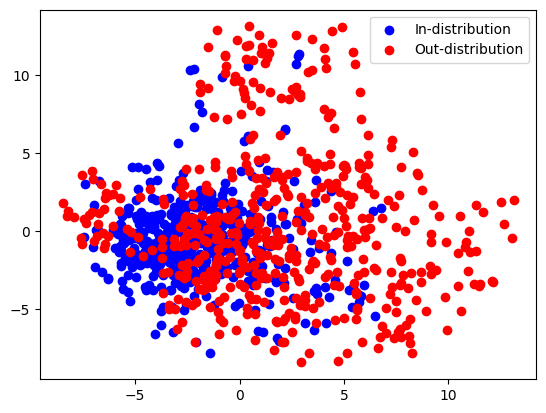

In [30]:
plt.scatter(pca_df[pca_df['actual']==0][0],pca_df[pca_df['actual']==0][1], c = "blue", label = "In-distribution")
plt.scatter(pca_df[pca_df['actual']==1][0],pca_df[pca_df['actual']==1][1], c = "red", label = "Out-distribution")
plt.legend()
plt.show()

## PCA with 3 components

In [ ]:
pca = PCA(n_components=3)
pca.fit(new_df.iloc[:,2:770])
pca_3d = pd.DataFrame(pca.transform(new_df.iloc[:,2:770]))
pca_3d['actual'] = new_df['actual']
pca_3d

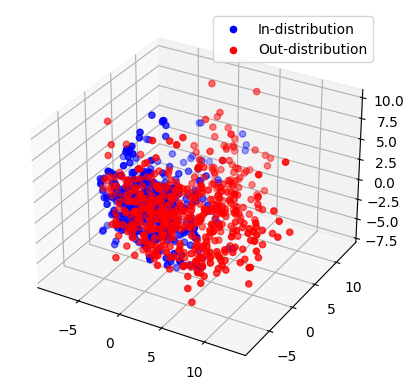

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pca_3d[pca_3d['actual']==0][0],pca_3d[pca_3d['actual']==0][1],
            pca_3d[pca_3d['actual']==0][2], c = "blue", label = "In-distribution")
ax.scatter3D(pca_3d[pca_3d['actual']==1][0],pca_3d[pca_3d['actual']==1][1],
            pca_3d[pca_3d['actual']==0][2], c = "red", label = "Out-distribution")
ax.legend()
plt.show()

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(pca_3d, x=pca_3d[0].values, y=pca_3d[1].values, z=pca_3d[2].values,
              color=pca_3d['actual'])
fig.show()

# OOD Detection

In paper e E(xin) = -11.19 and E(xout) = -7.11. They use negative energy scores for images(b & d) to align with the convention that positive (in-distribution) samples
have higher scores

<Figure size 50x480 with 0 Axes>

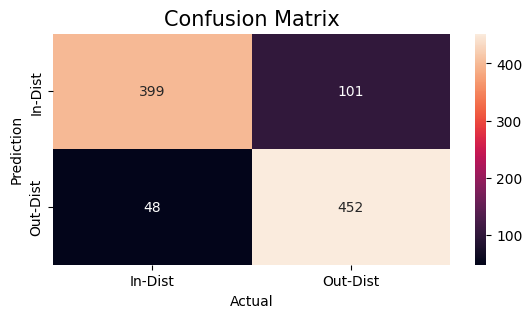

Accuracy :  0.851
Precision :  0.8173598553345389
Recall :  0.904
f1 :  0.858499525166192


In [31]:
# If -9.96 comes the negative value or -9.96 is smaller than -9.1 so it is 0
# If -8.60 comes the -8.60 is bigger than -9.1 so it is 1
# Here 1 means the data is out of distribution and 0 means its in-distribution
# The more the negative value it will be in-distribution
y_pred = [1 if i>=-9.1 else 0 for i in new_df['predicted']]
y_test = new_df['actual']
result(y_test ,y_pred)

# Cluster_df creation

Data Samples that are classified as out-of-distribution are now put into the cluster_df

In wdc test dataset we have the column unseen which takes value either True or False. When the columns has a value as True it means the data is out of distribution and vice versa.

In [32]:
cluster_df = new_df[new_df['predicted']>=-9.1]
# Here 1 means the data is out of distribution and 0 means its in-distribution

In [33]:
cluster_df.head(5)

,actual,predicted,0,1,2,3,4,5,6,7,...,759,760,761,762,763,764,765,766,767,cluster_id
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074
3,1,-7.340762,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,...,0.660271,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,174229
10,1,-6.997177,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,-0.039799,...,-0.288591,-0.549238,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380,1591273
13,1,-6.864704,0.471274,-0.002246,1.229759,0.280112,0.403729,-0.857715,-0.105573,0.259071,...,0.372874,1.581545,2.038446,-1.385646,0.909028,0.300855,0.219613,-0.569454,-0.442791,26514
15,1,-6.781733,0.750674,0.145004,1.579312,-1.116959,0.818048,2.676772,-0.482675,0.291191,...,0.165438,0.745066,-1.168148,-0.501723,0.316420,0.283938,-0.778661,-0.281374,0.608146,1819719


In [34]:
cluster_df.shape

(553, 771)

In [35]:
cluster_df["actual"].value_counts()

1    452
0    101
Name: actual, dtype: int64

In [36]:
print("Number of actual unique cluster:",cluster_df["cluster_id"].nunique())
print("Number of unique cluster with size = 2 :",sum(cluster_df["cluster_id"].value_counts().values ==2))
print("Number of unique cluster with size = 1 :",sum(cluster_df["cluster_id"].value_counts().values ==1))
print("***************")
print("Number of cluster with size 2 and is out-of-distribution",sum(cluster_df[cluster_df["actual"]==1]["cluster_id"].value_counts() == 2))
print("Number of cluster with size 1 and is out-of-distribution",sum(cluster_df[cluster_df["actual"]==1]["cluster_id"].value_counts() == 1))
print("***************")
print("Number of cluster with size 2 and is in-distribution",sum(cluster_df[cluster_df["actual"]==0]["cluster_id"].value_counts() == 2))
print("Number of cluster with size 1 and is in-distribution",sum(cluster_df[cluster_df["actual"]==0]["cluster_id"].value_counts() == 1))

Number of actual unique cluster: 313
Number of unique cluster with size = 2 : 240
Number of unique cluster with size = 1 : 73
***************
Number of cluster with size 2 and is out-of-distribution 215
Number of cluster with size 1 and is out-of-distribution 22
***************
Number of cluster with size 2 and is in-distribution 25
Number of cluster with size 1 and is in-distribution 51


Fetching the actual Cluster_ids with size =2 and size = 1

In [37]:
unique_cluster_2 = cluster_df["cluster_id"].value_counts().index[cluster_df["cluster_id"].value_counts()==2].tolist()
unique_cluster_1 = cluster_df["cluster_id"].value_counts().index[cluster_df["cluster_id"].value_counts()==1].tolist()

In [38]:
cluster_train_df = cluster_df.copy()
cluster_train_df.drop(["actual","predicted","cluster_id"],axis=1,inplace=True)

In [39]:
cluster_train_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
1,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,-0.402692,0.801399,...,-0.681062,0.357826,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090
3,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,0.179710,0.931786,...,-1.023829,0.660271,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375
10,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,-0.039799,-0.771645,-0.193203,...,0.682860,-0.288591,-0.549238,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380


# Cluster visualization before and after OOD

In [40]:
pca_df["prediction"] = cluster_df["cluster_id"]

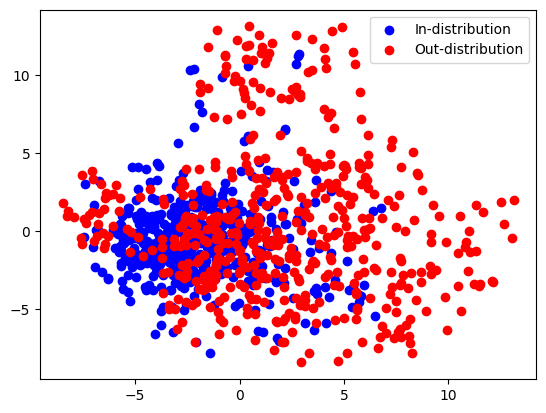

In [41]:
plt.scatter(pca_df[pca_df['actual']==0][0],pca_df[pca_df['actual']==0][1], c = "blue",  marker = "o", label = "In-distribution")
plt.scatter(pca_df[pca_df['actual']==1][0],pca_df[pca_df['actual']==1][1], c = "red",  marker = "o", label = "Out-distribution")
plt.legend()
plt.show()

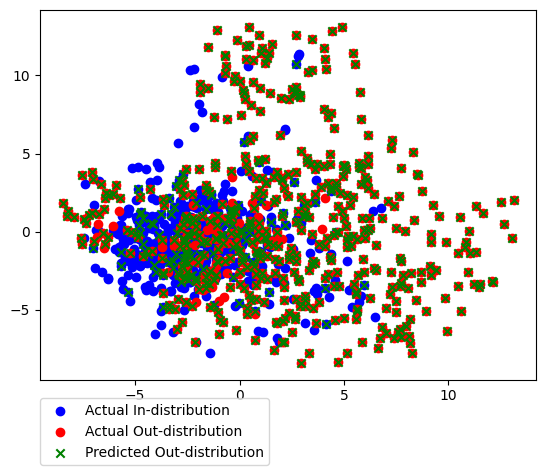

In [42]:
plt.style.use('default')
plt.scatter(pca_df[pca_df['actual']==0][0],pca_df[pca_df['actual']==0][1], c = "blue",  marker = "o", label = "Actual In-distribution")
plt.scatter(pca_df[pca_df['actual']==1][0],pca_df[pca_df['actual']==1][1], c = "red", marker = "o", label = "Actual Out-distribution")
plt.scatter(pca_df[pca_df['prediction']>0][0],pca_df[pca_df['prediction']>0][1], c = "green", marker = "x" , label = "Predicted Out-distribution")
plt.legend(bbox_to_anchor=(0, -0.05), loc='upper left', borderaxespad=0)

plt.show()

# Analyzing the predicted OOD

In [43]:
cluster_df.shape

(553, 771)

In [44]:
df_analyzer = pd.concat([pca_df,test_df], axis = 1)
df_analyzer = df_analyzer.fillna(-1)
df_analyzer.head(3)

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int
0,-4.999837,-1.368118,0,-1.0,84745207,Oki,OKI C831/841 Cyan Toner 10K,,219.74,GBP,,796023,796023,False,0
1,1.408364,11.446928,1,1382074.0,39759360,,"Garmin Forerunner 735XT - Replacement Band, Ye...",Stay stylish and sport-ready by swapping out y...,39.93,AUD,,1382074,1382074,True,1
2,-5.174199,-1.926827,0,-1.0,14159368,,Original Epson T8651 Black Ink Cartridge (C13T...,Buy Epson T8651 original high capacity black i...,,,,193507,193507,False,0


In [45]:
df_analyzer[(df_analyzer["cluster_id"]==3747560) ]

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int
31,-2.642938,-1.936109,0,3747560.0,44054804,,652564-B21 HP G8 G9 300-GB 6G 10K 2.5 SAS SC,Description: HP 300GB 2.5-inch (SFF) Serial At...,170,CAD,,3747560,3747560,False,0
355,-3.744374,-1.633791,0,-1.0,19697930,,652564-B21 300GB 10kRPM 2.5inch SAS-6G SC Ente...,652564-B21 300GB 10kRPM 2.5inch SAS-6G SC Ente...,28.81,USD,,3747560,3747560,False,0


## False Positive

In [46]:
false_positive = df_analyzer[(df_analyzer["actual"]==0) & (df_analyzer["prediction"]>0)]

In [47]:
false_positive.shape

(101, 15)

In [48]:
false_positive.head(2)

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int
21,4.398582,2.569867,0,103881.0,95721809,,"DYMO Black on Yellow Label Printer Tape, 24 mm...","Machine suitability:- Dymo LabelManager 300, L...",67.740,AUD,,103881,103881,False,0
31,-2.642938,-1.936109,0,3747560.0,44054804,,652564-B21 HP G8 G9 300-GB 6G 10K 2.5 SAS SC,Description: HP 300GB 2.5-inch (SFF) Serial At...,170,CAD,,3747560,3747560,False,0


### False Positive Similarity Check

#### TF-IDF

In [ ]:
cosine_df["title"] = test_df["title"]

In [ ]:
false_pos_sim = pd.merge(false_positive,cosine_df, how="inner", left_on = "title", right_on="title")

In [ ]:
false_pos_sim.shape

(101, 25)

In [ ]:
false_pos_sim.head(3)

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,...,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim False,unseen_int
0,4.403729,2.574651,0,103881.0,95721809,-1,"DYMO Black on Yellow Label Printer Tape, 24 mm...","Machine suitability:- Dymo LabelManager 300, L...",67.740,AUD,...,706825,0.3566,103881,0.0239,1001541,0.0145,1473407,0.145,0.271,0
1,-2.646524,-1.931347,0,3747560.0,44054804,-1,652564-B21 HP G8 G9 300-GB 6G 10K 2.5 SAS SC,Description: HP 300GB 2.5-inch (SFF) Serial At...,170,CAD,...,1082673,0.7060,603762,0.0532,893695,0.0388,1856741,0.092,0.515,0
2,-2.079441,-2.959595,0,393711.0,26736430,Sigma,Sigma 50mm F1.4 Art DG HSM Nikon Mount Lens,Sigma 50mm F1.4 Art DG HSM Nikon Mount Lens,1249,AUD,...,289139,0.8851,393711,0.0641,6496595,0.0907,336149,0.144,0.767,0


In [ ]:
false_pos_sim.describe()

,0,1,actual,prediction,id,specTableContent,cluster_id,label,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim False,unseen_int
count,101.000000,101.000000,101.0,1.010000e+02,1.010000e+02,101.0,1.010000e+02,1.010000e+02,101.000000,1.010000e+02,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.000000,101.0
mean,-1.435871,-0.296453,0.0,1.440226e+06,4.477975e+07,-1.0,1.440226e+06,1.440226e+06,0.197260,9.563549e+06,0.554271,1.717030e+06,0.052104,0.048940,0.140277,0.391000,0.0
std,2.656771,2.472048,0.0,5.257012e+06,2.662234e+07,0.0,5.257012e+06,5.257012e+06,0.115261,1.993246e+07,0.201340,5.261637e+06,0.025526,0.028649,0.081254,0.150041,0.0
min,-7.006411,-5.901200,0.0,4.559000e+03,1.970599e+06,-1.0,4.559000e+03,4.559000e+03,0.000000,1.656440e+05,0.091100,4.559000e+03,0.000000,0.012800,0.000000,0.087000,0.0
25%,-3.196275,-1.931347,0.0,1.183900e+05,2.395874e+07,-1.0,1.183900e+05,1.183900e+05,0.128200,9.463090e+05,0.371300,1.994600e+05,0.036600,0.028300,0.092000,0.288000,0.0
50%,-2.058930,-0.214269,0.0,3.993190e+05,4.466500e+07,-1.0,3.993190e+05,3.993190e+05,0.178100,1.944045e+06,0.572700,6.653270e+05,0.049000,0.042200,0.124000,0.379000,0.0
75%,0.202349,1.136460,0.0,1.164344e+06,6.179483e+07,-1.0,1.164344e+06,1.164344e+06,0.229400,3.603908e+06,0.719400,1.915191e+06,0.064100,0.059900,0.170000,0.492000,0.0
max,5.957043,10.738114,0.0,5.235830e+07,9.886604e+07,-1.0,5.235830e+07,5.235830e+07,0.761500,7.368242e+07,0.893400,5.235830e+07,0.149500,0.143400,0.447000,0.767000,0.0


#### Word Co-Occ

In [ ]:
false_positive.head(1)

,index,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen
0,21,4.403729,2.574651,0,103881.0,95721809,-1,"DYMO Black on Yellow Label Printer Tape, 24 mm...","Machine suitability:- Dymo LabelManager 300, L...",67.740,AUD,-1.0,103881,103881,False


In [ ]:
false_positive.reset_index(inplace=True)

In [ ]:
word_co_occ_df.reset_index(inplace=True)

In [ ]:
word_co_occ_df

In [ ]:
false_pos_word_co_occ = pd.merge(false_positive,word_co_occ_df, how="inner", left_on = "index", right_on="index")

In [ ]:
false_pos_word_co_occ.describe()

,index,0,1,actual,prediction,id,specTableContent,cluster_id,label,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,101.000000,101.000000,101.000000,101.0,1.010000e+02,1.010000e+02,101.0,1.010000e+02,1.010000e+02,101.000000,1.010000e+02,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.000000,101.0
mean,539.425743,-1.435871,-0.296453,0.0,1.440226e+06,4.477975e+07,-1.0,1.440226e+06,1.440226e+06,0.251822,5.520893e+06,0.604350,1.666040e+06,0.085265,0.077016,0.188564,0.452802,0.0
std,283.478442,2.656771,2.472048,0.0,5.257012e+06,2.662234e+07,0.0,5.257012e+06,5.257012e+06,0.129312,1.405703e+07,0.190001,5.275332e+06,0.025834,0.030282,0.097641,0.146087,0.0
min,21.000000,-7.006411,-5.901200,0.0,4.559000e+03,1.970599e+06,-1.0,4.559000e+03,4.559000e+03,0.000000,1.259120e+05,0.200000,4.559000e+03,0.000000,0.030700,0.000000,0.155000,0.0
25%,295.000000,-3.196275,-1.931347,0.0,1.183900e+05,2.395874e+07,-1.0,1.183900e+05,1.183900e+05,0.166700,8.977120e+05,0.447200,1.994600e+05,0.074500,0.055700,0.139000,0.351000,0.0
50%,555.000000,-2.058930,-0.214269,0.0,3.993190e+05,4.466500e+07,-1.0,3.993190e+05,3.993190e+05,0.239000,1.865913e+06,0.629900,5.910420e+05,0.086700,0.074500,0.179000,0.464000,0.0
75%,792.000000,0.202349,1.136460,0.0,1.164344e+06,6.179483e+07,-1.0,1.164344e+06,1.164344e+06,0.308600,3.250894e+06,0.730300,1.824443e+06,0.096200,0.089100,0.237000,0.560000,0.0
max,994.000000,5.957043,10.738114,0.0,5.235830e+07,9.886604e+07,-1.0,5.235830e+07,5.235830e+07,0.857100,7.368242e+07,0.925800,5.235830e+07,0.142900,0.187300,0.540000,0.784000,0.0


#### Jaccard Similarity

In [51]:
false_positive.reset_index(inplace=True)

In [52]:
jaccard_sim_df.reset_index(inplace=True)

In [53]:
false_pos_jaccard_sim = pd.merge(false_positive,jaccard_sim_df, how="inner", left_on = "index", right_on="index")

In [54]:
false_pos_jaccard_sim.describe()

,index,0,1,actual,prediction,id,cluster_id,label,unseen_int_x,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int_y
count,101.000000,101.000000,101.000000,101.0,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,101.0,101.000000,1.010000e+02,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.000000,101.0
mean,539.425743,-1.436877,-0.295516,0.0,1.440226e+06,4.477975e+07,1.440226e+06,1.440226e+06,0.0,0.111333,4.031018e+06,0.337454,1.149325e+06,0.037530,0.043071,0.079802,0.207713,0.0
std,283.478442,2.656765,2.473726,0.0,5.257012e+06,2.662234e+07,5.257012e+06,5.257012e+06,0.0,0.101505,8.910029e+06,0.197129,1.347958e+06,0.020391,0.022228,0.059996,0.112981,0.0
min,21.000000,-7.027964,-5.896625,0.0,4.559000e+03,1.970599e+06,4.559000e+03,4.559000e+03,0.0,0.000000,1.742290e+05,0.000000,2.180900e+04,0.000000,0.000000,0.000000,0.000000,0.0
25%,295.000000,-3.198267,-1.936109,0.0,1.183900e+05,2.395874e+07,1.183900e+05,1.183900e+05,0.0,0.069000,1.382074e+06,0.166700,1.935070e+05,0.031200,0.025600,0.054000,0.123000,0.0
50%,555.000000,-2.067479,-0.210653,0.0,3.993190e+05,4.466500e+07,3.993190e+05,3.993190e+05,0.0,0.090900,1.944045e+06,0.300000,5.804550e+05,0.040000,0.038500,0.077000,0.203000,0.0
75%,792.000000,0.192791,1.152466,0.0,1.164344e+06,6.179483e+07,1.164344e+06,1.164344e+06,0.0,0.133300,3.603908e+06,0.500000,1.824443e+06,0.050000,0.052600,0.095000,0.271000,0.0
max,994.000000,5.971454,10.741193,0.0,5.235830e+07,9.886604e+07,5.235830e+07,5.235830e+07,0.0,0.777800,6.802452e+07,0.818200,6.140563e+06,0.083300,0.153800,0.373000,0.562000,0.0


### Plotting the false positive that is model predicted it as out-of-distribution but it was in-distribution

In [ ]:
fp_dict = list_dictator(false_positive, "prediction", "cluster_id")
# fp_dict

In [ ]:
row_counter(fp_dict)

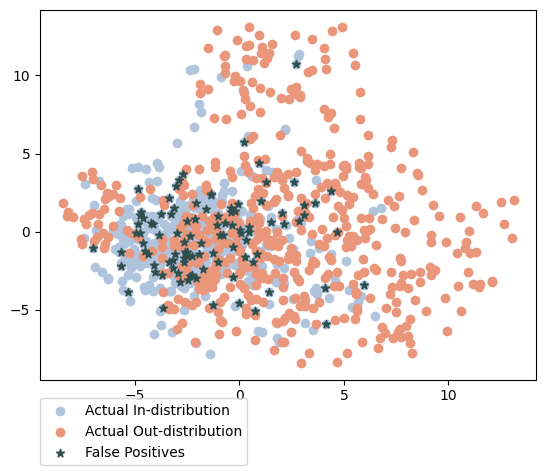

In [ ]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
plt.scatter(df_analyzer[df_analyzer['actual']==0][0],df_analyzer[df_analyzer['actual']==0][1], c = "lightsteelblue",
            marker = "o", label = "Actual In-distribution")
plt.scatter(df_analyzer[df_analyzer['actual']==1][0],df_analyzer[df_analyzer['actual']==1][1], c = "darksalmon",
            marker = "o", label = "Actual Out-distribution")
plt.scatter(df_analyzer[(df_analyzer["actual"]==0) & (df_analyzer["prediction"]>0)][0],
            df_analyzer[(df_analyzer["actual"]==0) & (df_analyzer["prediction"]>0)][1], c = "darkslategrey",
            marker = "*", label = "False Positives")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(bbox_to_anchor=(0, -0.05), loc='upper left', borderaxespad=0)
plt.show()

## False Negative

### Plotting the false negative that is model predicted it as in-distribution but it was out-of-distribution

In [55]:
false_negative = df_analyzer[(df_analyzer["actual"]==1) & (df_analyzer["prediction"]==-1)]

In [56]:
false_negative.head(2)

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,specTableContent,cluster_id,label,unseen,unseen_int
6,4.071785,2.144910,1,-1.0,4338951,,Manfrotto MK290LTA3 Video Tripod with Fluid Head,"For vlogging, travel and other mobile video pu...",279.95,AUD,,977750,977750,True,1
8,-6.764647,0.501167,1,-1.0,81714923,,"Samsung 860 PRO 2.5\"" 512 GB Serial ATA III 3D...","860 Pro, 512GB, 6.35 cm (2.5\"") , SATA 6GB/s, ...",263.52,EUR,,893695,893695,True,1


In [57]:
false_negative.shape

(48, 15)

In [58]:
fn_dict = list_dictator(false_negative, "cluster_id", "cluster_id")
# fn_dict

In [59]:
row_counter(fn_dict)

Number of single rows:  22
Number of more than 1 row:  13


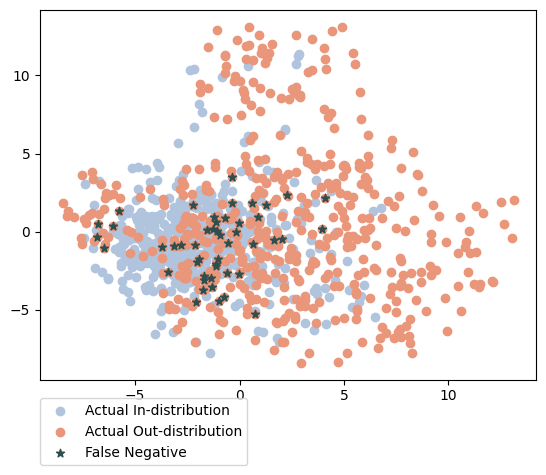

In [60]:
plt.scatter(df_analyzer[df_analyzer['actual']==0][0],df_analyzer[df_analyzer['actual']==0][1], c = "lightsteelblue",
            marker = "o", label = "Actual In-distribution")
plt.scatter(df_analyzer[df_analyzer['actual']==1][0],df_analyzer[df_analyzer['actual']==1][1], c = "darksalmon",
            marker = "o", label = "Actual Out-distribution")
plt.scatter(df_analyzer[(df_analyzer["actual"]==1) & (df_analyzer["prediction"]==-1)][0],
            df_analyzer[(df_analyzer["actual"]==1) & (df_analyzer["prediction"]==-1)][1], c = "darkslategrey",
            marker = "*", label = "False Negative")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(bbox_to_anchor=(0, -0.05), loc='upper left', borderaxespad=0)
plt.show()

### False Negaive Similarity Check

#### TF-IDF

In [ ]:
false_neg_sim = pd.merge(false_negative,cosine_df, how="inner", left_on = "title", right_on="title")

In [ ]:
false_neg_sim.shape

(48, 25)

In [ ]:
false_neg_sim.head(3)

,0,1,actual,prediction,id,brand,title,description,price,priceCurrency,...,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim Out-Dist ID,Min_Sim In-Dist,Min_Sim In-Dist ID,Avg Sim Out-Dist,Avg Sim False,unseen_int
0,4.085242,2.132741,1,-1.0,4338951,-1,Manfrotto MK290LTA3 Video Tripod with Fluid Head,"For vlogging, travel and other mobile video pu...",279.95,AUD,...,1865913,0.1536,788533,0.0859,2269949,0.0749,192122,0.380,0.137,1
1,-6.770496,0.504841,1,-1.0,81714923,-1,"Samsung 860 PRO 2.5\"" 512 GB Serial ATA III 3D...","860 Pro, 512GB, 6.35 cm (2.5\"") , SATA 6GB/s, ...",263.52,EUR,...,2681318,0.1662,3065693,0.0389,16659693,0.0375,1856741,0.193,0.150,1
2,-0.372542,1.854852,1,-1.0,12382662,Jabra,Jabra Evolve 20 UC cuffia mono per Skype for B...,-1,"€ 28,00",EUR,...,979862,0.2641,666306,0.0729,2814157,0.0502,472648,0.330,0.245,1


In [ ]:
false_neg_sim.describe()

,0,1,actual,prediction,id,specTableContent,cluster_id,label,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim False,unseen_int
count,48.000000,48.000000,48.0,48.0,4.800000e+01,48.0,4.800000e+01,4.800000e+01,48.000000,4.800000e+01,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.0
mean,-1.250004,-0.804320,1.0,-1.0,4.734472e+07,-1.0,6.743667e+06,6.743667e+06,0.571200,8.295683e+06,0.310454,2.117830e+06,0.051825,0.046979,0.354021,0.222104,1.0
std,2.395900,2.041670,0.0,0.0,2.848657e+07,0.0,1.535009e+07,1.535009e+07,0.191207,1.698734e+07,0.186216,7.481160e+06,0.021014,0.021423,0.146139,0.115812,0.0
min,-6.833409,-5.305381,1.0,-1.0,2.088770e+06,-1.0,2.989700e+04,2.989700e+04,0.128000,2.989700e+04,0.097400,4.559000e+03,0.026000,0.015800,0.120000,0.059000,1.0
25%,-2.026389,-2.341810,1.0,-1.0,2.168301e+07,-1.0,9.567362e+05,9.567362e+05,0.431325,1.600551e+06,0.165325,4.061642e+05,0.038475,0.032850,0.259250,0.146000,1.0
50%,-1.108976,-0.642618,1.0,-1.0,4.917732e+07,-1.0,2.836178e+06,2.836178e+06,0.612550,3.094120e+06,0.251800,5.747770e+05,0.046150,0.042500,0.331000,0.187500,1.0
75%,-0.147386,0.552939,1.0,-1.0,6.555379e+07,-1.0,3.969096e+06,3.969096e+06,0.710500,4.228273e+06,0.398800,1.655199e+06,0.059025,0.052700,0.450500,0.276250,1.0
max,4.085242,3.513417,1.0,-1.0,9.700813e+07,-1.0,7.368242e+07,7.368242e+07,0.934500,7.368242e+07,0.875800,5.235830e+07,0.128600,0.141400,0.658000,0.573000,1.0


#### Word Co-Occ

In [ ]:
false_negative.reset_index(inplace=True)

In [ ]:
false_neg_word_co_occ = pd.merge(false_negative,word_co_occ_df, how="inner", left_on = "index", right_on="index")

In [ ]:
false_neg_word_co_occ.shape

(48, 26)

In [ ]:
false_neg_word_co_occ.describe()

,index,0,1,actual,prediction,id,specTableContent,cluster_id,label,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int
count,48.000000,48.000000,48.000000,48.0,48.0,4.800000e+01,48.0,4.800000e+01,4.800000e+01,48.000000,4.800000e+01,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.0
mean,457.375000,-1.250004,-0.804320,1.0,-1.0,4.734472e+07,-1.0,6.743667e+06,6.743667e+06,0.616008,6.641485e+06,0.366546,1.921757e+06,0.088615,0.079435,0.409229,0.280938,1.0
std,289.642158,2.395900,2.041670,0.0,0.0,2.848657e+07,0.0,1.535009e+07,1.535009e+07,0.178608,1.536017e+07,0.176819,7.473872e+06,0.023468,0.021242,0.154117,0.125491,0.0
min,6.000000,-6.833409,-5.305381,1.0,-1.0,2.088770e+06,-1.0,2.989700e+04,2.989700e+04,0.227900,2.989700e+04,0.142900,4.843500e+04,0.050000,0.031400,0.169000,0.059000,1.0
25%,208.500000,-2.026389,-2.341810,1.0,-1.0,2.168301e+07,-1.0,9.567362e+05,9.567362e+05,0.494525,9.593245e+05,0.236975,4.061642e+05,0.073050,0.065225,0.307250,0.194500,1.0
50%,453.500000,-1.108976,-0.642618,1.0,-1.0,4.917732e+07,-1.0,2.836178e+06,2.836178e+06,0.635200,2.630374e+06,0.315000,5.782645e+05,0.086700,0.078600,0.379000,0.237500,1.0
75%,659.500000,-0.147386,0.552939,1.0,-1.0,6.555379e+07,-1.0,3.969096e+06,3.969096e+06,0.730300,3.908988e+06,0.451125,1.059233e+06,0.101275,0.091300,0.525250,0.364750,1.0
max,966.000000,4.085242,3.513417,1.0,-1.0,9.700813e+07,-1.0,7.368242e+07,7.368242e+07,0.935400,7.368242e+07,0.866000,5.235830e+07,0.158100,0.142900,0.723000,0.663000,1.0


#### Jaccard Similarity

In [61]:
false_negative.reset_index(inplace=True)

In [62]:
false_neg_jaccard_sim = pd.merge(false_negative,jaccard_sim_df, how="inner", left_on = "index", right_on="index")

In [63]:
false_neg_jaccard_sim.shape

(48, 27)

In [64]:
false_neg_jaccard_sim.describe()

,index,0,1,actual,prediction,id,cluster_id,label,unseen_int_x,Max_Sim Out-Dist,Max_Sim Out-Dist ID,Max_Sim In-Dist,Max_Sim In-Dist ID,Min_Sim Out-Dist,Min_Sim In-Dist,Avg Sim Out-Dist,Avg Sim In-Dist,unseen_int_y
count,48.000000,48.000000,48.000000,48.0,48.0,4.800000e+01,4.800000e+01,4.800000e+01,48.0,48.000000,4.800000e+01,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.0
mean,457.375000,-1.249655,-0.805844,1.0,-1.0,4.734472e+07,6.743667e+06,6.743667e+06,1.0,0.367471,7.186358e+06,0.192863,2.080710e+06,0.050210,0.039492,0.205563,0.130125,1.0
std,289.642158,2.394069,2.037853,0.0,0.0,2.848657e+07,1.535009e+07,1.535009e+07,0.0,0.225775,1.534740e+07,0.134620,7.468112e+06,0.028199,0.016585,0.130322,0.075760,0.0
min,6.000000,-6.832443,-5.305125,1.0,-1.0,2.088770e+06,2.989700e+04,2.989700e+04,1.0,0.041700,2.989700e+04,0.000000,7.923800e+04,0.027000,0.000000,0.025000,0.000000,1.0
25%,208.500000,-2.030539,-2.322724,1.0,-1.0,2.168301e+07,9.567362e+05,9.567362e+05,1.0,0.166700,9.898820e+05,0.102550,4.137340e+05,0.036375,0.030300,0.116250,0.080000,1.0
50%,453.500000,-1.108175,-0.647704,1.0,-1.0,4.917732e+07,2.836178e+06,2.836178e+06,1.0,0.333300,2.855402e+06,0.153800,7.141150e+05,0.042600,0.035700,0.170000,0.102500,1.0
75%,659.500000,-0.147832,0.556401,1.0,-1.0,6.555379e+07,3.969096e+06,3.969096e+06,1.0,0.500000,5.438738e+06,0.232975,1.167862e+06,0.053350,0.044000,0.275000,0.158750,1.0
max,966.000000,4.071785,3.487887,1.0,-1.0,9.700813e+07,7.368242e+07,7.368242e+07,1.0,0.833300,7.368242e+07,0.750000,5.235830e+07,0.200000,0.100000,0.511000,0.386000,1.0


# DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors

# By default Number of neighbors to use is 5
neigh = NearestNeighbors()
nbrs = neigh.fit(cluster_df.iloc[:,2:770])
distances, indices = nbrs.kneighbors(cluster_df.iloc[:,2:770])

In [ ]:
print("Shape of distance matrix:",distances.shape)
for enum, row in enumerate(distances[:5]):
  print("Data point " + str(enum) + ":" +  str([round(x,2) for x in row]))
print("---------------------")
print("Indices:\n",indices[:5])

Shape of distance matrix: (553, 5)
Data point 0:[0.0, 7.65, 7.81, 8.4, 8.78]
Data point 1:[0.0, 13.74, 24.14, 24.21, 24.41]
Data point 2:[0.0, 24.62, 24.92, 25.37, 25.93]
Data point 3:[0.0, 19.0, 22.41, 24.08, 25.37]
Data point 4:[0.0, 14.67, 14.8, 15.39, 17.86]
---------------------
Indices:
 [[  0 342 178  38  46]
 [  1 203 550 214 361]
 [  2 435 362 404 179]
 [  3  30 494  83 196]
 [  4 335  85  41  11]]


In the above result the first index is 0 because when k = 1, it is computing the distance with itself. We can see it from the output of indices. Now if we look into the column 1, for data point 0 is the 1st closest neighbour is data point 342 which is at a distance of 7.65

Now to plot the kdist plot we sort the distances across the rows, that is we take a column then sort it across the rows in asceding order. The x axis is the data point or its index. The distance value sorted is the distance of the data points to its 3rd closest neighbour. When the points are close the distance will be less, when the distance starts increasing it means it is going to a lower density region

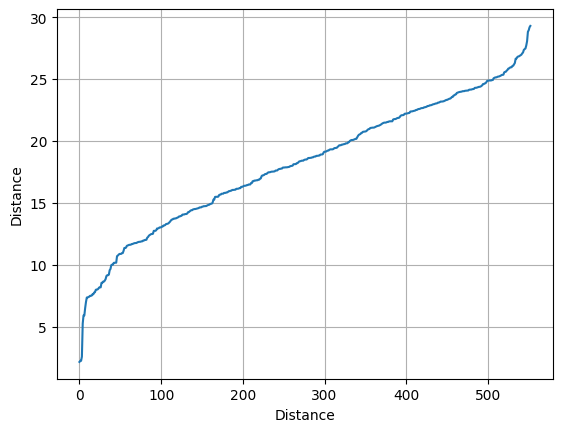

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,2]
plt.plot(distances)
plt.grid(True)
plt.xlabel("Distance")
plt.ylabel("Distance")
plt.show()

In [ ]:
clustering = DBSCAN(eps=17.5, min_samples=2).fit(cluster_df.iloc[:,2:770])
print("NUmber of unique clusters predicted:",len(set(clustering.labels_)))
clustering.labels_

NUmber of unique clusters predicted: 100


array([ 0,  1, -1, -1,  2,  3, -1,  4,  5, -1,  6,  2,  7,  8, -1,  9, 10,
       11, 12, 13, 14, -1, -1, -1, -1, 14, 12, 15, -1, -1, -1, 16, -1, -1,
       -1, 17, 18, 19,  0, 20, 21,  2, 22, -1, 18, 23,  0, 12, 24, 25, -1,
       26, -1, 27, 28, 29, -1, -1, 30, -1, 31, 32,  8, 33, -1, 20, -1, 34,
       35, -1, 11, 36, -1, 37, 38, 39, 16, 40, 25, 41, 42, 43, -1, -1, -1,
        2, 35, -1, 21, -1, 44, -1, 45, -1, 10, -1, 17, -1, 46, -1, 47, 48,
       49, -1, 50, -1, 26, 19, 51, 45, 18, 12, 52, -1, 53, 19, 46, 54, 12,
       55, 12, 56, 57, 58, -1, 53, 12, 51, -1, -1, 30, 14, 54, 59, 54, 25,
       -1, 60, -1, -1, -1, -1, 61, -1, -1, 44, 62, 14, -1, -1, 63, 64, -1,
       44, -1, -1, 63, 65, -1, -1, -1, 66, -1, 39, 67, 68, -1, 69, 66, 54,
       -1,  7, -1, 61, 25, -1, 29, 42,  0, -1,  4, 15, -1, 19, -1, 46, 61,
       -1, 15, 45, 70, -1, 27, -1, 34, 71, 22, 72, -1, -1, 19, 60, 39,  1,
       13, 35, 61, 73, 39, 52, 57, 27,  4, 54, -1,  8, 74, -1, 35, -1, 10,
       -1, 68, 75,  4, 35

## DBSCAN Evaluation

In [ ]:
dbscan_df = cluster_df.copy()
dbscan_df["predicted_clusters"] = clustering.labels_
dbscan_df.head(5)

,actual,predicted,0,1,2,3,4,5,6,7,...,760,761,762,763,764,765,766,767,cluster_id,predicted_clusters
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074,0
3,1,-7.340762,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,...,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,174229,1
10,1,-6.997177,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,-0.039799,...,-0.549238,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380,1591273,-1
13,1,-6.864704,0.471274,-0.002246,1.229759,0.280112,0.403729,-0.857715,-0.105573,0.259071,...,1.581545,2.038446,-1.385646,0.909028,0.300855,0.219613,-0.569454,-0.442791,26514,-1
15,1,-6.781733,0.750674,0.145004,1.579312,-1.116959,0.818048,2.676772,-0.482675,0.291191,...,0.745066,-1.168148,-0.501723,0.316420,0.283938,-0.778661,-0.281374,0.608146,1819719,2


In [ ]:
# labels_true, labels_pred
arc = adjusted_rand_score(dbscan_df["cluster_id"], dbscan_df["predicted_clusters"])
rc = rand_score(dbscan_df["cluster_id"], dbscan_df["predicted_clusters"])
print("adjusted_rand_score:",arc)
print("rand_score:",rc)

adjusted_rand_score: 0.017813582948913248
rand_score: 0.8886704929632833


In [ ]:
dbscan_df.shape

(553, 772)

## Plot showing the noise points and the core points

In [ ]:
reset_dbscan_df = dbscan_df.reset_index()
reset_dbscan_df

,index,actual,predicted,0,1,2,3,4,5,6,...,760,761,762,763,764,765,766,767,cluster_id,predicted_clusters
0,1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,...,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074,0
1,3,1,-7.340762,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,...,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,174229,1
2,10,1,-6.997177,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,...,-0.549238,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380,1591273,-1
3,13,1,-6.864704,0.471274,-0.002246,1.229759,0.280112,0.403729,-0.857715,-0.105573,...,1.581545,2.038446,-1.385646,0.909028,0.300855,0.219613,-0.569454,-0.442791,26514,-1
4,15,1,-6.781733,0.750674,0.145004,1.579312,-1.116959,0.818048,2.676772,-0.482675,...,0.745066,-1.168148,-0.501723,0.316420,0.283938,-0.778661,-0.281374,0.608146,1819719,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,994,0,-7.240526,1.386672,0.046845,0.225183,-0.814733,0.227944,-0.710881,0.906248,...,1.920243,-0.115108,-1.445528,0.438700,-0.162470,0.108247,-0.330462,0.400713,1913870,-1
549,995,1,-6.713562,1.555387,0.456348,1.566642,-0.399241,-1.637178,1.922582,0.209420,...,-0.349313,-0.583888,-0.890458,0.697593,0.533642,0.312274,0.331528,-0.835965,6128077,2
550,997,1,-7.273738,0.396754,0.864914,0.270161,-0.289791,0.323521,0.327413,-0.537613,...,0.763940,0.722095,0.288796,0.092775,-1.094780,-1.583572,0.596465,0.966363,45143961,-1
551,998,1,-7.854701,-0.495061,-0.063287,0.405469,-0.458071,0.191531,-0.948234,0.405667,...,2.028486,1.435738,-1.294210,-0.131744,0.640069,-0.092214,-0.350019,-1.209923,2043487,96


In [ ]:
pca = PCA(n_components=2)
pca.fit(reset_dbscan_df.iloc[:,2:770].reset_index())
X = pca.transform(reset_dbscan_df.iloc[:,2:770].reset_index())
pca__dbscan_df = pd.DataFrame(X)
pca__dbscan_df["predicted_clusters"] = reset_dbscan_df["predicted_clusters"]
pca__dbscan_df

,0,1,predicted_clusters
0,275.996626,-7.361573,0
1,274.979981,-4.348178,1
2,273.998847,-8.210424,-1
3,273.022553,6.365530,-1
4,272.010801,3.590309,2
...,...,...,...
548,-272.017627,1.079281,-1
549,-272.977465,3.622978,2
550,-274.045495,-5.809211,-1
551,-274.971841,1.805771,96


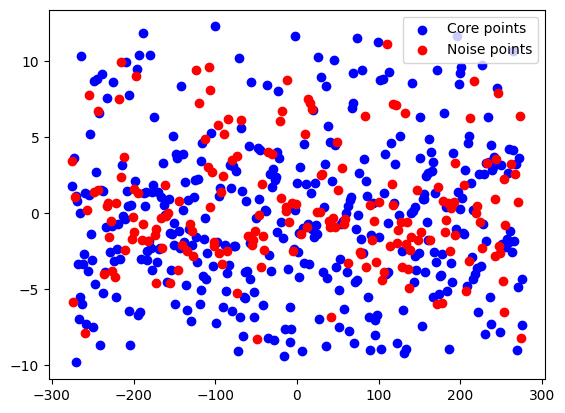

In [ ]:
plt.scatter(pca__dbscan_df[pca__dbscan_df['predicted_clusters']>=0][0],pca__dbscan_df[pca__dbscan_df['predicted_clusters']>=0][1],
            c = "blue", label = "Core points")
plt.scatter(pca__dbscan_df[pca__dbscan_df['predicted_clusters']==-1][0],pca__dbscan_df[pca__dbscan_df['predicted_clusters']==-1][1],
            c = "red", label = "Noise points")
plt.legend()
plt.show()

Creating a dictionary where the predicted_cluster_id is the key and the value is the list of actual_cluster_id

In [ ]:
dbscan_predicted_cluster_dict = dict()
for i in dbscan_df.index:
  predicted_clusters_id = dbscan_df["predicted_clusters"][i]
  actual_cluster_id = dbscan_df["cluster_id"][i]
  if predicted_clusters_id not in dbscan_predicted_cluster_dict:
    dbscan_predicted_cluster_dict[predicted_clusters_id] = [actual_cluster_id]
  else:
    dbscan_predicted_cluster_dict[predicted_clusters_id].append(actual_cluster_id)

In [ ]:
len(dbscan_predicted_cluster_dict.keys())

100

In [ ]:
dbscan_actual_cluster_dict = dict()
for i in dbscan_df.index:
  predicted_clusters_id = dbscan_df["predicted_clusters"][i]
  actual_cluster_id = dbscan_df["cluster_id"][i]
  if actual_cluster_id not in dbscan_actual_cluster_dict:
    dbscan_actual_cluster_dict[actual_cluster_id] = [predicted_clusters_id]
  else:
    dbscan_actual_cluster_dict[actual_cluster_id].append(predicted_clusters_id)

In [ ]:
dbscan_actual_cluster_dict

In [ ]:
count = 0
mis_classified = 0
single_cluster = 0
big_cluster = 0
for k,v in dbscan_actual_cluster_dict.items():
  if len(v)==2:
    if v[0]==v[1]:
      if v[0]== -1 and v[1]==-1:
        big_cluster =big_cluster +1
      else:
        count = count + 1
        print(k," ",v)
    else:
      mis_classified = mis_classified + 1
      # print(k," ",v)
  else:
    # print(k," ",v)
    single_cluster = single_cluster + 1
    # single_cluster_list.append(k)


print("Matched results:",count)
print("Mis_classified results:",mis_classified)
print("single_cluster:",single_cluster)
print("big_cluster:",big_cluster)

# K-Means

Manually check the number of clusters in the ood detected samples and put that actual number in the n_clusters

In [ ]:
from sklearn.cluster import KMeans
# Putting 313 since 313 clusters found for 80cc20rnd
kmean_clusters = KMeans(n_clusters=313, random_state=0)
kmean_clusters.fit(cluster_df.iloc[:,2:770])
cluster_assignment = kmean_clusters.labels_
print(cluster_assignment)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 55  99 214 215  96 289 227  32 108 232  88  17 158  68 226  73 256  45
  30  77  37  28 261  72 187 274 305  31 163 308 298  43 257 268 149 174
  22 195  55   8  60  96 111 238 157  13  55  30 121 125 134  64 154  15
  50 101 185 280  80 312 141  75   0 119 190   8 136 180 279 199  45 122
 130 106  35  12  43 104 212 118  92  14 116 269 272 225 137 287 273 248
 173 221  53 262  16 228 174 234  20   4 128  21  57 200  36 253  64 195
  39  53 157 305  40  94 192   7  20 115 305  76  30  29 113 132 100   3
  30  39  34 235  80  37 230 166 230   9 266  87 160 188  63 254  18 239
 129 173 103  37 140 242 107 110 168   6 196 111  33 138 161 247 206  19
 278  12  59  42 120  93  19 230  84 158 145 245   9 142   2  92  55  79
  32  31 151 195 293  20 245  74 191  53  89 175 208 217  26  25 111  66
  86  41  67  87  12  99  77 137  18 209  12  40 113  97  32  23 243  68
  85  48  10 265 276 281  42  65  32 137  67  82  81 159 157  70 299   8
  98 117 264  41  45 112  55   9  30 182  76 283  3

In [ ]:
kmeans_df = cluster_df.copy()
kmeans_df["predicted_clusters"] = cluster_assignment
kmeans_df.head(5)

,actual,predicted,0,1,2,3,4,5,6,7,...,760,761,762,763,764,765,766,767,cluster_id,predicted_clusters
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.459477,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074,55
3,1,-7.340762,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,...,0.109673,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,174229,99
10,1,-6.997177,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,-0.039799,...,-0.549238,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380,1591273,214
13,1,-6.864704,0.471274,-0.002246,1.229759,0.280112,0.403729,-0.857715,-0.105573,0.259071,...,1.581545,2.038446,-1.385646,0.909028,0.300855,0.219613,-0.569454,-0.442791,26514,215
15,1,-6.781733,0.750674,0.145004,1.579312,-1.116959,0.818048,2.676772,-0.482675,0.291191,...,0.745066,-1.168148,-0.501723,0.316420,0.283938,-0.778661,-0.281374,0.608146,1819719,96


## KMeans Evaluation

In [ ]:
# labels_true, labels_pred
arc = adjusted_rand_score(kmeans_df["cluster_id"], kmeans_df["predicted_clusters"])
rc = rand_score(kmeans_df["cluster_id"], kmeans_df["predicted_clusters"])
print("adjusted_rand_score:",arc)
print("rand_score:",rc)

adjusted_rand_score: 0.3100983683514466
rand_score: 0.9967568205047567


In [ ]:
homogeneity_score(kmeans_df["cluster_id"], kmeans_df["predicted_clusters"])

0.8877340752468387

In [ ]:
print("Number of actual unique cluster:",kmeans_df["cluster_id"].nunique())
print("Number of predicted unique cluster:",kmeans_df["predicted_clusters"].nunique())

Number of actual unique cluster: 313
Number of predicted unique cluster: 250


In [ ]:
kmeans_predicted_cluster_dict = dict()
for i in kmeans_df.index:
  predicted_clusters_id = kmeans_df["predicted_clusters"][i]
  actual_cluster_id = kmeans_df["cluster_id"][i]
  if predicted_clusters_id not in kmeans_predicted_cluster_dict:
    kmeans_predicted_cluster_dict[predicted_clusters_id] = [actual_cluster_id]
  else:
    kmeans_predicted_cluster_dict[predicted_clusters_id].append(actual_cluster_id)

In [ ]:
kmeans_predicted_cluster_dict

In [ ]:
kmeans_actual_cluster_dict = dict()
for i in kmeans_df.index:
  predicted_clusters_id = kmeans_df["predicted_clusters"][i]
  actual_cluster_id = kmeans_df["cluster_id"][i]
  if actual_cluster_id not in kmeans_actual_cluster_dict:
    kmeans_actual_cluster_dict[actual_cluster_id] = [predicted_clusters_id]
  else:
    kmeans_actual_cluster_dict[actual_cluster_id].append(predicted_clusters_id)

In [ ]:
kmeans_actual_cluster_dict

Predicted results

In [ ]:
label_enc = LabelEncoder()
kmeans_df['new_cluster_id']= label_enc.fit_transform(kmeans_df["cluster_id"])

In [ ]:
kmeans_df.head(5)

,actual,predicted,0,1,2,3,4,5,6,7,...,761,762,763,764,765,766,767,cluster_id,predicted_clusters,new_cluster_id
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074,57,140
3,1,-7.340762,-0.494637,1.239930,0.898205,-0.714954,-1.295674,-0.778296,0.128264,1.193648,...,0.345521,0.359992,-0.154462,0.195523,-0.430925,0.437538,-0.570375,174229,69,29
10,1,-6.997177,0.894009,-0.951783,-0.176800,0.050646,1.308311,1.790073,0.200588,-0.039799,...,-0.260060,-0.325747,-0.451267,-0.110346,1.572997,-0.378284,1.347380,1591273,179,149
13,1,-6.864704,0.471274,-0.002246,1.229759,0.280112,0.403729,-0.857715,-0.105573,0.259071,...,2.038446,-1.385646,0.909028,0.300855,0.219613,-0.569454,-0.442791,26514,172,2
15,1,-6.781733,0.750674,0.145004,1.579312,-1.116959,0.818048,2.676772,-0.482675,0.291191,...,-1.168148,-0.501723,0.316420,0.283938,-0.778661,-0.281374,0.608146,1819719,176,157


In [ ]:
from sklearn.metrics.cluster import completeness_score
# completeness_score(kmeans_df['new_cluster_id'],kmeans_df['predicted_clusters'])
completeness_score(kmeans_df['cluster_id'],kmeans_df['predicted'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.9047327580070398

In [ ]:
count = 0
mis_classified = 0
single_cluster = 0
single_cluster_list = []
for k,v in actual_cluster_dict.items():
  if len(v)==2:
    if v[0]==v[1]:
      count = count + 1
    else:
      mis_classified = mis_classified + 1
      # print(k," ",v)
  else:
    # print(k," ",v)
    single_cluster = single_cluster + 1
    single_cluster_list.append(k)


print("Matched results:",count)
print("Mis_classified results:",mis_classified)
print("single_cluster:",single_cluster)

Matched results: 140
Mis_classified results: 100
single_cluster: 73


Actual Result

In [ ]:
cluster_id_counts = kmeans_df['cluster_id'].value_counts()

print("Number of cluster with 2 samples:", len(cluster_id_counts[cluster_id_counts > 1]))
print("Number of cluster with 1 samples:", len(cluster_id_counts[cluster_id_counts == 1]))

Number of cluster with 2 samples: 240
Number of cluster with 1 samples: 73


In [ ]:
kmeans_df.sort_values("new_cluster_id")

,actual,predicted,0,1,2,3,4,5,6,7,...,761,762,763,764,765,766,767,cluster_id,predicted_clusters,new_cluster_id
877,0,-8.509084,0.589333,1.252146,0.246865,0.420912,0.059132,-1.217749,1.147580,-0.733951,...,1.232488,-0.708513,0.304414,0.717567,-1.352408,0.150725,-1.057450,4559,214,0
491,0,-8.848667,-0.348816,0.615442,0.889924,-0.277271,-0.054283,-0.447512,1.279002,-0.455109,...,1.310458,-1.022864,0.078755,-0.474466,-0.729991,0.116205,-0.404511,4559,214,0
968,0,-8.214244,0.200980,0.560642,-0.250517,-0.413034,-0.895222,-1.620742,0.518949,1.275232,...,-1.385093,-0.061365,0.814695,-0.784293,-0.788165,-0.091414,1.128152,21809,73,1
805,0,-8.286125,-0.078105,0.127891,0.324975,-0.700466,-0.686631,-1.472142,0.330683,1.824272,...,-0.839540,-1.010545,0.651162,-0.785110,-0.480118,0.120643,0.430733,21809,73,1
63,1,-7.069519,1.332021,-0.004519,0.098978,0.488136,-0.155237,0.199347,0.759030,0.522253,...,1.456480,-2.245500,0.311361,-1.028560,0.593127,0.184901,-0.572796,26514,172,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,-6.961236,0.290930,-0.651691,1.064973,-0.168706,-1.581546,-0.431512,0.389212,0.365956,...,-1.640795,0.078562,0.527138,-0.209118,-0.360315,0.124634,-0.972161,72054429,20,310
958,1,-6.768604,0.522890,-0.423512,1.203019,0.036103,-0.927683,-1.688883,1.146688,0.097876,...,0.198704,-0.406832,0.780901,-0.449999,-0.323504,-1.377091,-1.729365,72054429,102,310
127,1,-8.857678,1.033517,-0.381499,0.357300,0.003578,-0.171997,1.378411,0.169523,0.311053,...,-0.614779,-0.137454,-1.738064,0.535426,-0.053641,-0.134090,-1.339307,73682420,144,311
439,1,-6.852621,0.114573,-0.818595,-0.132469,1.308575,1.346956,-1.001626,-0.050487,-0.224023,...,1.415674,0.913957,-0.345355,1.655724,0.601936,0.521725,-0.727534,75758000,2,312


In [ ]:
kmeans_df[kmeans_df["predicted_clusters"]==57]

,actual,predicted,0,1,2,3,4,5,6,7,...,761,762,763,764,765,766,767,cluster_id,predicted_clusters,new_cluster_id
1,1,-8.609785,-1.128743,0.050721,1.305313,-0.162477,-1.512057,-0.605196,0.579833,1.423121,...,0.660360,-0.245644,1.073406,0.325545,-0.558094,0.469575,1.349090,1382074,57,140
75,1,-8.205175,-1.362413,0.244808,1.278021,-0.048655,-1.401225,-0.488041,0.151707,1.642006,...,0.368504,-0.038067,1.516657,-0.080509,-0.114280,0.156934,1.276153,1326265,57,138
90,1,-8.243359,-0.829288,0.327618,0.891761,0.116260,-1.290389,-0.853201,0.392277,1.682007,...,0.075326,-0.431420,1.776925,-0.058275,-0.106209,0.633641,0.720381,1550524,57,146
322,1,-8.500564,-1.280372,0.195722,1.683475,-0.163077,-2.167825,-0.182382,0.892853,1.611175,...,0.628528,-0.236129,1.060802,0.168750,-1.011327,0.362891,1.721960,1202204,57,130
437,1,-8.535833,-1.746573,0.413750,1.224177,0.066955,-0.118904,-0.768558,0.874447,1.188950,...,0.294164,-0.662841,1.589293,-0.494599,0.399471,-0.011847,0.063576,1082673,57,126
614,1,-8.708147,-1.054913,-0.018576,0.868281,0.219989,-0.654780,-0.791061,0.315108,1.700561,...,0.387668,-0.213381,1.384272,-0.056465,-0.065161,0.357702,0.598970,1326265,57,138
622,1,-7.985172,-1.640671,0.721493,0.529409,-0.078008,-0.849914,-0.403558,0.674480,1.703798,...,0.039946,-0.660636,0.874211,0.198835,-1.868572,0.585664,1.631229,1202204,57,130
675,1,-7.950133,-0.897754,0.740615,1.284726,-0.051468,0.059960,-0.474835,0.787202,1.960598,...,0.400509,-0.519345,1.402972,-0.016952,0.426776,-0.430717,1.115680,3909321,57,231
718,1,-8.536446,-0.799718,0.174713,0.912690,0.216287,-0.748888,-0.560744,0.105360,1.923877,...,0.164987,-0.524583,1.539694,-0.069587,-0.168876,0.433183,0.709466,1550524,57,146


In [ ]:
single_cluster_list

In [ ]:
unique_cluster_1

In [ ]:
len(set(single_cluster_list).intersection(set(unique_cluster_1)))

73

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(kmeans_df["cluster_id"], kmeans_df["predicted_clusters"])

# Calculate the Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(kmeans_df["cluster_id"], kmeans_df["predicted_clusters"])

print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.31779873909620926
Normalized Mutual Information (NMI): 0.9244637882975401


In [ ]:
# actual =    [0,1,2,0,2,0,1,2]
# predicted = [5,6,5,6,5,5,5,6]
actual =    kmeans_df["new_cluster_id"]
predicted = kmeans_df["predicted_clusters"]
acc = accuracy_score(actual,predicted)
precision = precision_score(actual,predicted,average='weighted')
recall = recall_score(actual,predicted, average='weighted')
f1 = f1_score(actual,predicted,average='weighted')
print("Accuracy : ",acc)
print("Precision : ",precision)
print("Recall : ",recall)
print("f1 : ",f1)

Accuracy :  0.0018083182640144665
Precision :  0.0012055455093429777
Recall :  0.0018083182640144665
f1 :  0.0014466546112115732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Sample DataFrame with cluster_id and predicted_cluster_id columns
data = {'cluster_id': [123456, 234567, 345678, 456789],
        'predicted_cluster_id': [2, 1, 0, 2]}
df = pd.DataFrame(data)
df


,cluster_id,predicted_cluster_id
0,123456,2
1,234567,1
2,345678,0
3,456789,2


In [ ]:
# Define a mapping from predicted clusters to actual clusters
cluster_mapping = {
    0: 123456,  # Map predicted cluster 0 to actual cluster 123456
    1: 234567,  # Map predicted cluster 1 to actual cluster 234567
    2: 345678,  # Map predicted cluster 2 to actual cluster 345678
    # Add more mappings for other clusters as needed
}

# Create a new column with actual cluster labels based on the mapping
df['actual_cluster_id'] = df['predicted_cluster_id'].map(cluster_mapping)

# Display the DataFrame with actual cluster labels
(df)

,cluster_id,predicted_cluster_id,actual_cluster_id
0,123456,2,345678
1,234567,1,234567
2,345678,0,123456
3,456789,2,345678


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Replace these with your actual cluster assignments and actual labels
cluster_assignments = [0, 1, 2, 0, 1, 2, 3, 4, 3, 4]
actual_labels =       [1, 1, 2, 1, 2, 2, 3, 4, 3, 4]
                      [1, 1, 2, 1, 1, 2, 3, 4, 3, 4]

# Calculate Accuracy
accuracy = accuracy_score(actual_labels, cluster_assignments)

# Create a mapping between cluster labels and actual labels
cluster_to_actual_label = {}
for cluster_label in set(cluster_assignments):
    cluster_points = [actual_labels[i] for i in range(len(cluster_assignments)) if cluster_assignments[i] == cluster_label]
    most_common_actual_label = max(set(cluster_points), key=cluster_points.count)
    cluster_to_actual_label[cluster_label] = most_common_actual_label

# Map cluster assignments to actual labels
mapped_cluster_assignments = [cluster_to_actual_label[label] for label in cluster_assignments]
print(mapped_cluster_assignments)

# Calculate Precision and Recall
precision = precision_score(actual_labels, mapped_cluster_assignments, average='weighted')
recall = recall_score(actual_labels, mapped_cluster_assignments, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


[1, 1, 2, 1, 1, 2, 3, 4, 3, 4]
Accuracy: 0.70
Precision: 0.93
Recall: 0.90


In [ ]:

sumofsq = {}
for k in range(1,250):
    km = KMeans(n_clusters=k,init='k-means++',max_iter=1000)
    km = km.fit(cluster_df.iloc[:,2:770])
    sumofsq[k] = km.inertia_

In [ ]:
sumofsq_keys = list(sumofsq.keys())
key_list = [sumofsq_keys[i] for i in range(0, len(sumofsq_keys), 25)]
key_list

[1, 26, 51, 76, 101, 126, 151, 176, 201, 226]

In [ ]:
sumofsq_values = list(sumofsq.values())
value_list = [sumofsq_values[i] for i in range(0, len(sumofsq_values), 25)]
value_list

[276245.9989044485,
 179920.74690324962,
 139876.90782701698,
 115435.64379209655,
 98063.7544840933,
 83044.31869790137,
 70924.7098220912,
 60015.40319554024,
 50907.326634495075,
 42970.85642345264]

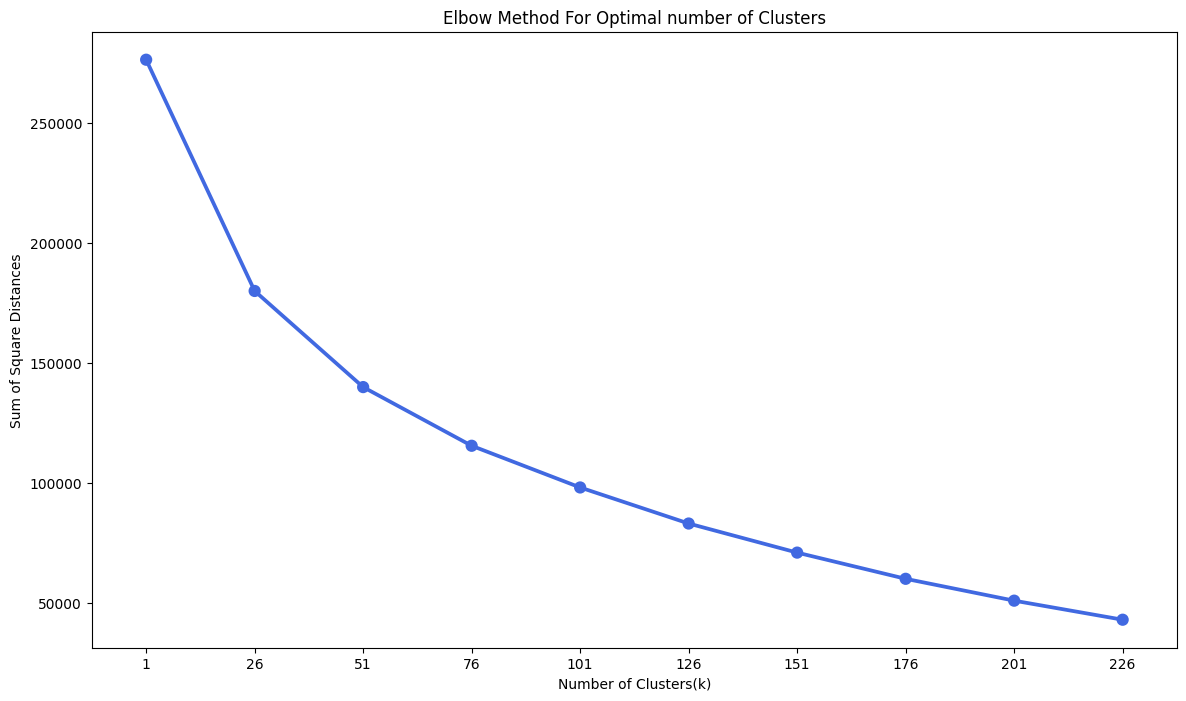

In [ ]:
plt.figure(figsize=(14,8))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal number of Clusters')
sns.pointplot(x=key_list,y=value_list,color='royalblue')
plt.show()

In [ ]:
import plotly.express as px
px.scatter(data_frame=kmeans_df,x='predicted',y='0',color='predicted_clusters',template='plotly_dark')


# Validation dataset

## Small validation set

In [ ]:
file_path = "/content/drive/My Drive/OOD/wdcproductsmulti80cc20rnd050un_valid_small.json.gz"
valid_small_df = pd.read_json(file_path,lines=True)
valid_small_df

,id,brand,title,description,price,priceCurrency,cluster_id,label,unseen
0,59868206,Logitech,Logitech C922 Pro Stream Webcam (960-001090),Connect with superior clarity every time you g...,"10,140.00",INR,58883,58883,False
1,19213335,None,"Philips Master LED MR16, ExpertColor CRI92, 7....",MASTER LEDspot ExpertColor (CRI92) MR16 7.5W=4...,1.367E1,GBP,3328908,3328908,True
2,81395161,Corsair,"Corsair CC-9011101-WW Crystal Series 460X RGB,...",We've engineered the crystal 460X RGB to pack ...,131.99,USD,1320095,1320095,False
3,33334612,None,"12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...","12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...",443.99,USD,2860605,2860605,True
4,25150282,None,New Era Cappello Raiders Unisex,None,25.00,EUR,5710284,5710284,True
...,...,...,...,...,...,...,...,...,...
995,44726488,Brother,Brother HL-L6300DW Business Laser Printer for ...,"Business durable design with fast, high-qualit...",349.98,USD,408446,408446,False
996,54112792,Logitech,Logitech C270 webcam 3 MP 1280 x 720 Pixels US...,"HD Webcam C270, 3 MP, 1280 x 720, USB 2.0, Flu...",52.04,EUR,79254,79254,False
997,38112967,None,HIKVISION DS-7216HQHI-K1 2 MEGAPIXEL (2MP) HYB...,The HIKVISION DS-7216HQHI-K1 is the Fourth Gen...,None,None,4045323,4045323,False
998,54500223,None,HyperX 8GB (2x4GB) 1600MHz CL10 Fury Blue,None,289,PLN,288081,288081,False


In [ ]:
valid_small_df[valid_small_df["cluster_id"]==58883]

,id,brand,title,description,price,priceCurrency,cluster_id,label,unseen
0,59868206,Logitech,Logitech C922 Pro Stream Webcam (960-001090),Connect with superior clarity every time you g...,"10,140.00",INR,58883,58883,False
120,29716234,None,LOGITECH C922 PRO STREAM FULL HD WEBCAM (960-0...,Warranty : 1 Year with Local Distributor - Ban...,189.00,SGD,58883,58883,False


## Medium validation set

In [ ]:
file_path = "/content/drive/My Drive/OOD/wdcproductsmulti80cc20rnd050un_valid_medium.json.gz"
valid_medium_df = pd.read_json(file_path,lines=True)
valid_medium_df

,id,brand,title,description,price,priceCurrency,cluster_id,label,unseen
0,43443246,RAM,UNPKG RAM DBL SOCKET ARM B BALL A LENGTH,None,22.00,EUR,394619,394619,False
1,74427858,Beko,BEKO DTLCE80041W 8KG CONDENSER DRYER B RATED,Tumble DryersBrand NameBekoStackableYesManufac...,239.99,GBP,1424479,1424479,True
2,81395161,Corsair,"Corsair CC-9011101-WW Crystal Series 460X RGB,...",We've engineered the crystal 460X RGB to pack ...,131.99,USD,1320095,1320095,False
3,33334612,None,"12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...","12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...",443.99,USD,2860605,2860605,True
4,25150282,None,New Era Cappello Raiders Unisex,None,25.00,EUR,5710284,5710284,True
...,...,...,...,...,...,...,...,...,...
995,44726488,Brother,Brother HL-L6300DW Business Laser Printer for ...,"Business durable design with fast, high-qualit...",349.98,USD,408446,408446,False
996,54112792,Logitech,Logitech C270 webcam 3 MP 1280 x 720 Pixels US...,"HD Webcam C270, 3 MP, 1280 x 720, USB 2.0, Flu...",52.04,EUR,79254,79254,False
997,15417028,None,"Samsung CF390 27"" 4ms HDMI Curved Monitor","Samsung CF390 27"" 4ms HDMI Curved Monitor",175.88,GBP,709380,709380,False
998,54500223,None,HyperX 8GB (2x4GB) 1600MHz CL10 Fury Blue,None,289,PLN,288081,288081,False


In [ ]:
valid_medium_df[valid_medium_df["cluster_id"]==58883]

,id,brand,title,description,price,priceCurrency,cluster_id,label,unseen
144,29716234,None,LOGITECH C922 PRO STREAM FULL HD WEBCAM (960-0...,Warranty : 1 Year with Local Distributor - Ban...,189.00,SGD,58883,58883,False
256,59868206,Logitech,Logitech C922 Pro Stream Webcam (960-001090),Connect with superior clarity every time you g...,"10,140.00",INR,58883,58883,False


## Large validation set

In [ ]:
file_path = "/content/drive/My Drive/OOD/wdcproductsmulti80cc20rnd050un_valid_large.json.gz"
valid_large_df = pd.read_json(file_path,lines=True)
valid_large_df

,id,brand,title,description,price,priceCurrency,cluster_id,label,unseen
0,91421742,Garmin,Garmin Fēnix® 5S Plus Sapphire Black 010-01987...,"For athletes and outdoor adventurers, the fēni...",666.58,EUR,785440,785440,True
1,19213335,None,"Philips Master LED MR16, ExpertColor CRI92, 7....",MASTER LEDspot ExpertColor (CRI92) MR16 7.5W=4...,1.367E1,GBP,3328908,3328908,True
2,81395161,Corsair,"Corsair CC-9011101-WW Crystal Series 460X RGB,...",We've engineered the crystal 460X RGB to pack ...,131.99,USD,1320095,1320095,False
3,33334612,None,"12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...","12TB IronWolf Pro ST12000NE0007, 7200 RPM, SAT...",443.99,USD,2860605,2860605,True
4,76893002,None,Blaze 34-Inch Grill Cart For: 3 Burner Profess...,Stainless steel construction is durable in out...,1.09999E3,USD,6140563,6140563,False
...,...,...,...,...,...,...,...,...,...
995,6469852,None,"Seiko Mens Prospex Divers Watch, SRPD11K1.","Seiko Mens Divers Automatic Watch, SRPD11K1. A...",470,GBP,4296365,4296365,True
996,83362334,Razer,RAZER MAMBA ELITE ERGONOMIC WIRED GAMING MOUSE,"Incredibly Accurate: True 16,000 DPI 5G Optica...",6649.00,INR,967973,967973,False
997,38112967,None,HIKVISION DS-7216HQHI-K1 2 MEGAPIXEL (2MP) HYB...,The HIKVISION DS-7216HQHI-K1 is the Fourth Gen...,None,None,4045323,4045323,False
998,54500223,None,HyperX 8GB (2x4GB) 1600MHz CL10 Fury Blue,None,289,PLN,288081,288081,False


In [ ]:
valid_large_df.iloc[873,:]

id                                               43443246
brand                                                 RAM
title            UNPKG RAM DBL SOCKET ARM B BALL A LENGTH
description                                          None
price                                               22.00
priceCurrency                                         EUR
cluster_id                                         394619
label                                              394619
unseen                                              False
Name: 873, dtype: object

In [ ]:
print("Number of cluster with unseen == True",valid_large_df[valid_large_df["unseen"]==True]["cluster_id"].nunique())
print("Number of cluster with unseen == False",valid_large_df[valid_large_df["unseen"]==False]["cluster_id"].nunique())

Number of cluster with unseen == True 250
Number of cluster with unseen == False 250


# Training Set Creation for OOD Detection

In [ ]:
file_path = "/content/drive/My Drive/OOD/"
energy_score_df1 = pd.read_csv(file_path+'Prob_Density_WDC_wdcproductsmulti80cc20rnd050un.csv').drop("Unnamed: 0",axis=1)
# energy_score_df = pd.read_csv('../Clustering/Prob_Density_WDC_wdcproductsmulti80cc20rnd050un.csv').drop("Unnamed: 0",axis=1)
energy_score_df1

,actual,predicted
0,0,-9.968505
1,1,-8.609785
2,0,-9.433629
3,1,-7.340762
4,0,-10.454275
...,...,...
995,1,-6.713562
996,0,-10.721281
997,1,-7.273738
998,1,-7.854701


In [ ]:
energy_score_df2 = pd.read_csv(file_path+'Prob_Density_WDC_wdcproductsmulti80cc20rnd050un_valid_large_Roberta-base.csv').drop("Unnamed: 0",axis=1)
# energy_score_df = pd.read_csv('../Clustering/Prob_Density_WDC_wdcproductsmulti80cc20rnd100unRoberta-base.csv').drop("Unnamed: 0",axis=1)
energy_score_df2

,actual,predicted
0,1,-8.278280
1,1,-7.514219
2,0,-10.370277
3,1,-8.734291
4,0,-9.899822
...,...,...
995,1,-9.851101
996,0,-10.360264
997,0,-9.466063
998,0,-8.767303


In [ ]:
print("Size of dataframe 1: ",energy_score_df1.shape)
print("Size of dataframe 2: ",energy_score_df2.shape)

Size of dataframe 1:  (1000, 2)
Size of dataframe 2:  (1000, 2)


In [ ]:
df = pd.concat([energy_score_df1,energy_score_df2], axis = 0)
df.shape

(2000, 2)

In [ ]:
df["energy_score"] = df["predicted"]
df["label"] = df["actual"]
df = df.reset_index()
df.drop(["actual","predicted","index"],axis=1, inplace = True)

In [ ]:
df

,energy_score,label
0,-9.968505,0
1,-8.609785,1
2,-9.433629,0
3,-7.340762,1
4,-10.454275,0
...,...,...
1995,-9.851101,1
1996,-10.360264,0
1997,-9.466063,0
1998,-8.767303,0


In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:0

In [ ]:
# This is required else the from pycaret.classification import * fails
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.1.0 requires scipy~=1.10.1, but you have scipy 1.11.3 which is incompatible.


# Training the mode

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.classification import *

In [ ]:
train, test = train_test_split(df,test_size=0.2,random_state=42)
print("train.shape: ",train.shape)
print("test.shape: ",test.shape)

train.shape:  (1600, 2)
test.shape:  (400, 2)


In [ ]:
reg1 = setup(data = train, target = 'label',train_size=0.7)

,Description,Value
0,Session id,6376
1,Target,label
2,Target type,Binary
3,Original data shape,"(1600, 2)"
4,Transformed data shape,"(1600, 2)"
5,Transformed train set shape,"(1120, 2)"
6,Transformed test set shape,"(480, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8411,0.9092,0.8377,0.8497,0.8421,0.6821,0.6847,0.1250
gbc,Gradient Boosting Classifier,0.8366,0.9109,0.8430,0.8374,0.8389,0.6732,0.6752,0.1300
lightgbm,Light Gradient Boosting Machine,0.8366,0.9068,0.8305,0.8459,0.8373,0.6732,0.6747,0.1530
lr,Logistic Regression,0.8339,0.9164,0.8182,0.8497,0.8328,0.6679,0.6697,0.5120
nb,Naive Bayes,0.8330,0.9164,0.8076,0.8558,0.8301,0.6663,0.6686,0.0270
qda,Quadratic Discriminant Analysis,0.8330,0.9164,0.8076,0.8558,0.8301,0.6663,0.6686,0.0500
ridge,Ridge Classifier,0.8321,0.0000,0.8058,0.8555,0.8289,0.6645,0.6670,0.0420
lda,Linear Discriminant Analysis,0.8321,0.9164,0.8058,0.8555,0.8289,0.6645,0.6670,0.0280
xgboost,Extreme Gradient Boosting,0.8304,0.9075,0.8253,0.8414,0.8311,0.6608,0.6643,0.0820
knn,K Neighbors Classifier,0.8241,0.8934,0.8094,0.8413,0.8233,0.6483,0.6514,0.0470


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
ada = create_model('ada')
preds=predict_model(ada, data = test.drop(columns=["label"]))
preds

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8036,0.8997,0.7544,0.8431,0.7963,0.6078,0.6113
1,0.8036,0.8954,0.8596,0.7778,0.8167,0.6063,0.6098
2,0.8393,0.9049,0.8070,0.8679,0.8364,0.6789,0.6806
3,0.8214,0.8700,0.8070,0.8364,0.8214,0.6430,0.6434
4,0.8750,0.9337,0.8421,0.9057,0.8727,0.7502,0.7522
5,0.8125,0.8848,0.8421,0.8000,0.8205,0.6245,0.6254
6,0.8214,0.8989,0.8929,0.7812,0.8333,0.6429,0.6495
7,0.8482,0.9233,0.7857,0.8980,0.8381,0.6964,0.7019
8,0.8929,0.9348,0.8750,0.9074,0.8909,0.7857,0.7862


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,energy_score,prediction_label,prediction_score
1860,-10.498947,0,0.5050
353,-7.717292,1,0.5076
1333,-10.691452,0,0.5387
905,-8.335734,1,0.5032
1289,-9.991015,0,0.5137
...,...,...,...
965,-7.558608,1,0.5112
1284,-9.765611,0,0.5112
1739,-6.822622,1,0.6361
261,-6.809495,1,0.6361


In [ ]:
lr = create_model('lr')
preds=predict_model(lr, data = test.drop(columns=["label"]))
preds

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7946,0.9021,0.7544,0.8269,0.7890,0.5898,0.5922
1,0.7946,0.8877,0.8246,0.7833,0.8034,0.5888,0.5896
2,0.8482,0.9285,0.8246,0.8704,0.8468,0.6966,0.6976
3,0.8125,0.8737,0.7895,0.8333,0.8108,0.6252,0.6261
4,0.8482,0.9400,0.8070,0.8846,0.8440,0.6968,0.6996
5,0.8214,0.8928,0.8246,0.8246,0.8246,0.6427,0.6427
6,0.8393,0.9184,0.8750,0.8167,0.8448,0.6786,0.6803
7,0.8393,0.9295,0.7679,0.8958,0.8269,0.6786,0.6856
8,0.8571,0.9394,0.8393,0.8704,0.8545,0.7143,0.7147


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,energy_score,prediction_label,prediction_score
1860,-10.498947,0,0.9549
353,-7.717292,1,0.8762
1333,-10.691452,0,0.9677
905,-8.335734,1,0.6992
1289,-9.991015,0,0.8945
...,...,...,...
965,-7.558608,1,0.9040
1284,-9.765611,0,0.8496
1739,-6.822622,1,0.9726
261,-6.809495,1,0.9732


<Figure size 50x480 with 0 Axes>

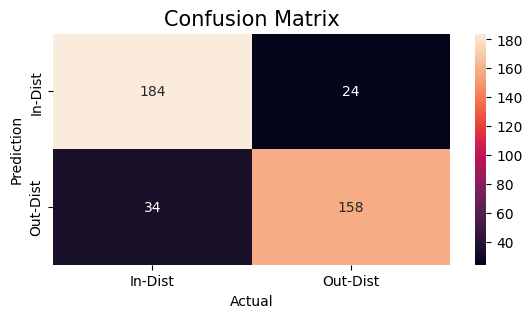

Accuracy :  0.855
Precision :  0.8681318681318682
Recall :  0.8229166666666666
f1 :  0.8449197860962567


In [ ]:
y_test = test["label"]
y_pred = preds["prediction_label"]
result(y_test ,y_pred)

<Figure size 50x480 with 0 Axes>

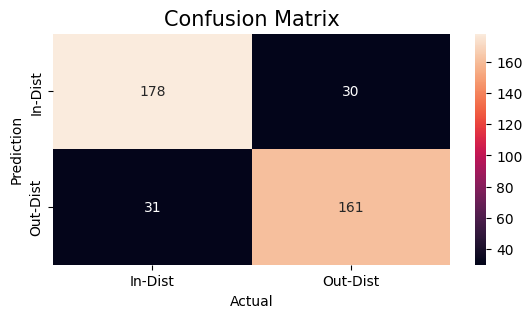

Accuracy :  0.8475
Precision :  0.8429319371727748
Recall :  0.8385416666666666
f1 :  0.8407310704960834


In [ ]:
y_test = test["label"]
y_pred = preds["prediction_label"]
result(y_test ,y_pred)

# Basic Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X = df["energy_score"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiate the model
logreg = LogisticRegression(random_state=42)


X_train = X_train.values.reshape(-1, 1)
# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logreg.predict(X_test.values.reshape(-1, 1))

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,

In [ ]:
logreg.score(X_test.values.reshape(-1, 1), y_test)

0.855

<Figure size 50x480 with 0 Axes>

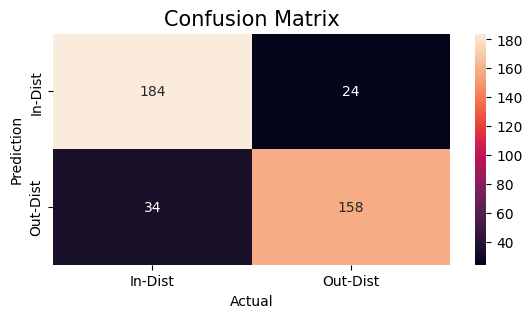

Accuracy :  0.855
Precision :  0.8681318681318682
Recall :  0.8229166666666666
f1 :  0.8449197860962567


In [ ]:
y_pred = logreg.predict(X_test.values.reshape(-1, 1))
y_test = y_test
result(y_test ,y_pred)

# Using Earlier threshold

<Figure size 50x480 with 0 Axes>

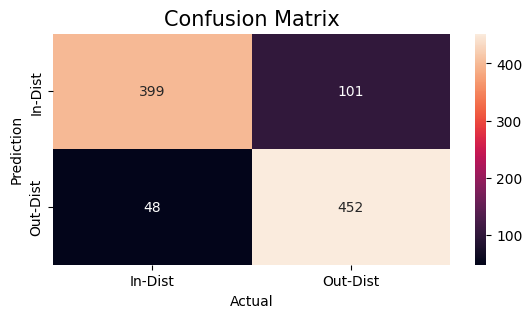

Accuracy :  0.851
Precision :  0.8173598553345389
Recall :  0.904
f1 :  0.858499525166192


In [ ]:
y_pred = [1 if i>=-9.1 else 0 for i in energy_score_df1['predicted']]
y_test = energy_score_df1['actual']
result(y_test ,y_pred)

<Figure size 50x480 with 0 Axes>

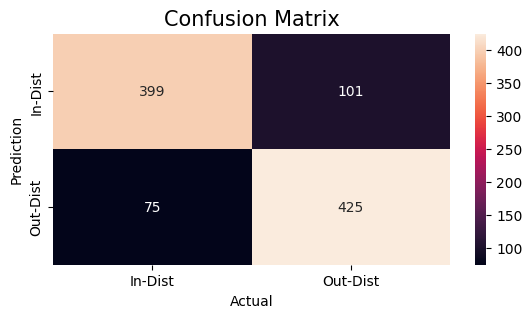

Accuracy :  0.824
Precision :  0.8079847908745247
Recall :  0.85
f1 :  0.8284600389863548


In [ ]:
y_pred = [1 if i>=-9.1 else 0 for i in energy_score_df2['predicted']]
y_test = energy_score_df2['actual']
result(y_test ,y_pred)

# wdc20cc80rnd

In [ ]:
file_path = "/content/drive/My Drive/OOD/"
energy_score_df_20cc80rnd = pd.read_csv(file_path+'Prob_Density_WDC_wdcproductsmulti20cc80rnd050un_Roberta-base.csv').drop("Unnamed: 0",axis=1)
energy_score_df_20cc80rnd

,actual,predicted
0,0,-9.960329
1,0,-10.433152
2,0,-10.601271
3,0,-8.469899
4,1,-7.030021
...,...,...
995,1,-8.595537
996,1,-6.975866
997,0,-10.353678
998,0,-10.118080


<Figure size 50x480 with 0 Axes>

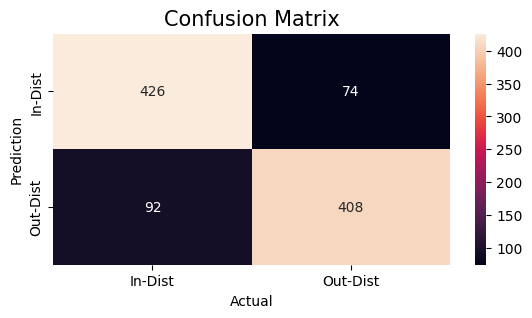

Accuracy :  0.834
Precision :  0.8464730290456431
Recall :  0.816
f1 :  0.8309572301425661


In [ ]:
y_pred = [1 if i>=-8.7 else 0 for i in energy_score_df_20cc80rnd['predicted']]
y_test = energy_score_df_20cc80rnd['actual']
result(y_test ,y_pred)

# wdc50cc50rnd

In [ ]:
file_path = "/content/drive/My Drive/OOD/"
energy_score_df_50cc50rnd = pd.read_csv(file_path+'Prob_Density_WDC_wdcproductsmulti50cc50rnd050un_Roberta-base.csv').drop("Unnamed: 0",axis=1)
energy_score_df_50cc50rnd

,actual,predicted
0,0,-10.161809
1,1,-7.742470
2,1,-7.074209
3,0,-9.121804
4,0,-10.353540
...,...,...
995,0,-9.677872
996,1,-8.821724
997,0,-9.025353
998,0,-9.694847


<Figure size 50x480 with 0 Axes>

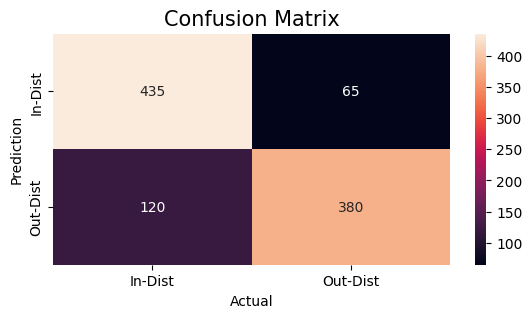

Accuracy :  0.815
Precision :  0.8539325842696629
Recall :  0.76
f1 :  0.8042328042328041


In [ ]:
y_pred = [1 if i>=-8.85 else 0 for i in energy_score_df_50cc50rnd['predicted']]
y_test = energy_score_df_50cc50rnd['actual']
result(y_test ,y_pred)